In [82]:
import fb_experiment
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from xgboost import XGBClassifier
import keras
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, GRU
from keras.layers import Dense, Dropout
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, Activation, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
fbetl = fb_experiment.FootballETL()

In [15]:
import requests
CSV_URL = 'https://www.football-data.co.uk/mmz4281/2223/E0.csv'
with requests.Session() as s:
    download = s.get(CSV_URL)
    open('premier_league_csv/odds/E0_2022.csv', 'w+').write(download.content.decode('utf-8'))

In [16]:
fb_games_df = fbetl.read_csv_files('premier_league_csv/odds/')

fyear: 2012
fyear: 2013
fyear: 2014
fyear: 2015
fyear: 2016
fyear: 2017
fyear: 2018
fyear: 2019
fyear: 2020
fyear: 2021
fyear: 2022


In [17]:
fb_games_df.tail(5)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
4066,E0,2023-03-18,Chelsea,Everton,2,2,D,0,0,D,...,1.71,-1.00,1.80,2.10,1.91,2.02,1.91,2.16,1.84,2.05
4068,E0,2023-03-18,Brentford,Leicester,1,1,D,1,0,H,...,2.12,-0.50,1.89,2.04,1.90,2.02,1.90,2.07,1.87,2.01
4064,E0,2023-03-18,Wolves,Leeds,2,4,A,0,1,A,...,1.68,-0.25,2.00,1.93,1.98,1.94,2.06,1.96,1.99,1.88
4065,E0,2023-03-18,Southampton,Tottenham,3,3,D,0,1,A,...,1.81,0.75,1.77,2.02,1.82,2.11,1.86,2.16,1.80,2.07
4069,E0,2023-03-19,Arsenal,Crystal Palace,4,1,H,2,0,H,...,2.19,-1.50,1.77,2.02,1.83,2.07,1.90,2.14,1.81,2.07


In [18]:
fb_games_df.HomeTeam = fb_games_df.HomeTeam.str.replace("'","")
fb_games_df.AwayTeam = fb_games_df.AwayTeam.str.replace("'","")

In [19]:
fb_games_df[['B365H','B365D','B365A','BWH','BWD','BWA','IWH','IWD','IWA','PSH','PSD','PSA',
            'WHH','WHD','WHA','VCH','VCD','VCA']]
fb_games_df['CAvgH'] = fb_games_df[['B365H','BWH','IWH','PSH','WHH']].mean(axis=1)
fb_games_df['CAvgA'] = fb_games_df[['B365A','BWA','IWA','PSA','WHA']].mean(axis=1)
fb_games_df['CAvgD'] = fb_games_df[['B365D','BWD','IWD','PSD','WHD']].mean(axis=1)

fb_games_df['CstdH'] = fb_games_df[['B365H','BWH','IWH','PSH','WHH']].std(axis=1)
fb_games_df['CstdA'] = fb_games_df[['B365A','BWA','IWA','PSA','WHA']].std(axis=1)
fb_games_df['CstdD'] = fb_games_df[['B365D','BWD','IWD','PSD','WHD']].std(axis=1)

In [20]:
fb_games_df = fbetl.add_date_types(fb_games_df)

In [21]:
fb_games_thin_df = fb_games_df[['FYear','Year','Month','Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR',
                                'CAvgH','CAvgD','CAvgA','CstdH','CstdD','CstdA','B365H', 'B365A', 'B365D']]

In [22]:
mvalue_df = fbetl.read_csv_files_mvalue('premier_league_csv/mvalue/')

In [23]:
a = list(fb_games_thin_df['HomeTeam'])

In [24]:
a.extend(fb_games_thin_df['AwayTeam'])
a = set(a)

In [25]:
for name in a:
    mvalue_df.loc[mvalue_df.Club.str.contains(name),'Club'] = name

In [26]:
mvalue_df.loc[mvalue_df.Club.str.contains('Aston'),'Club'] = 'Aston Villa'
mvalue_df.loc[mvalue_df.Club.str.contains('ManchesterUnited'),'Club'] = 'Man United'
mvalue_df.loc[mvalue_df.Club.str.contains('ManchesterCity'),'Club'] = 'Man City'
mvalue_df.loc[mvalue_df.Club.str.contains('CrystalPalace'),'Club'] = 'Crystal Palace'
mvalue_df.loc[mvalue_df.Club.str.contains('SheffieldUnited'),'Club'] = 'Sheffield United'
mvalue_df.loc[mvalue_df.Club.str.contains('WestBrom'),'Club'] = 'West Brom'
mvalue_df.loc[mvalue_df.Club.str.contains('WestHam'),'Club'] = 'West Ham'
mvalue_df.loc[mvalue_df.Club.str.contains('Wolver'),'Club'] = 'Wolves'
mvalue_df.loc[mvalue_df.Club.str.contains('Nottingham'),'Club'] = 'Nottm Forest'

In [27]:
mvalue_df['Totalmarketvalue'] = mvalue_df['Totalmarketvalue'].str.replace('m','').astype(float)

In [28]:
mvalue_df = mvalue_df.drop(['marketvalue','Foreigners'],axis=1)

In [29]:
mvalue_df[mvalue_df['FYear'] == 2015]

,Club,Squad,age,Totalmarketvalue,FYear
60,Chelsea,40,24.7,553.50,2015
61,Man City,38,25.4,499.35,2015
62,Arsenal,41,24.7,457.85,2015
63,Man United,44,23.5,439.85,2015
64,Liverpool,44,23.4,375.25,2015
65,Tottenham,31,23.7,371.85,2015
66,Everton,39,25.7,249.85,2015
67,Southampton,35,25.0,225.50,2015
68,West Ham,50,24.2,201.33,2015
69,Newcastle,42,24.5,198.00,2015


In [30]:
fb_games_m_df = pd.merge(fb_games_thin_df,mvalue_df.rename({'Club':'HomeTeam',
                                            'Squad':'HomeTeamSquad',
                                            'age':'HomeTeamAge',
                                            'Totalmarketvalue':'HomeTeamTmarketvalue'},axis=1), on=['HomeTeam','FYear'])

In [31]:
fb_games_m_df = pd.merge(fb_games_m_df,mvalue_df.rename({'Club':'AwayTeam',
                                            'Squad':'AwayTeamSquad',
                                            'age':'AwayTeamAge',
                                            'Totalmarketvalue':'AwayTeamTmarketvalue'},axis=1), on=['AwayTeam','FYear'])

In [32]:
epl_t = mvalue_df.Club.unique()

In [33]:
dates_df = fb_games_m_df[['FYear','Year','Month','Date']].drop_duplicates().sort_values('Date')

In [34]:
stand_df = pd.DataFrame()
for index, row in dates_df.iterrows():
    stand_df = stand_df.append(pd.DataFrame([np.repeat(np.array(fb_games_m_df.iloc[index]['Date']),
                                        len(epl_t)),epl_t,[0]*len(epl_t)]).transpose())
stand_df.columns = ['Date','Club','Points']

In [35]:
stand_df = pd.merge(dates_df, stand_df ,on='Date')

In [36]:
stand_df

,FYear,Year,Month,Date,Club,Points
0,2012,2012,8,2012-08-18,Manchester Cityﾠ,0
1,2012,2012,8,2012-08-18,Manchester United,0
2,2012,2012,8,2012-08-18,Chelsea,0
3,2012,2012,8,2012-08-18,Arsenal,0
4,2012,2012,8,2012-08-18,Tottenham,0
...,...,...,...,...,...,...
45675,2022,2023,3,2023-03-19,Wolves,0
45676,2022,2023,3,2023-03-19,Sheffield United,0
45677,2022,2023,3,2023-03-19,Leeds,0
45678,2022,2023,3,2023-03-19,Brentford,0


In [37]:
t_codes = pd.DataFrame([epl_t,range(len(epl_t))]).transpose()
t_codes.columns=['Club','Club_code']

In [38]:
stand_df['Points'] = 0
stand_df['GS'] = 0
stand_df['GC'] = 0
stand_df['AvgGS'] = 0
stand_df['AvgGC'] = 0

In [39]:
stand_dyn_df = pd.DataFrame(columns=['Date','Club','Points','GS','GC','AvgGS','AvgGC','GHS','GHC','GAS','GAC'])
stand_dyn_df['Points'] = 0
stand_dyn_df['GS'] = 0
stand_dyn_df['GC'] = 0
stand_dyn_df['AvgGS'] = 0
stand_dyn_df['AvgGC'] = 0

In [40]:
stand_dyn_df

,Date,Club,Points,GS,GC,AvgGS,AvgGC,GHS,GHC,GAS,GAC


In [41]:
fb_games_m_df[fb_games_m_df['Date'] == '2021-05-16']

,FYear,Year,Month,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,CstdA,B365H,B365A,B365D,HomeTeamSquad,HomeTeamAge,HomeTeamTmarketvalue,AwayTeamSquad,AwayTeamAge,AwayTeamTmarketvalue
2770,2020,2021,5,2021-05-16,Crystal Palace,Aston Villa,3,2,H,1,...,0.026077,3.00,2.25,3.60,36,27.7,193.85,53,23.3,430.75
2849,2020,2021,5,2021-05-16,West Brom,Liverpool,1,2,A,1,...,0.014142,12.00,1.22,6.50,43,26.1,141.15,43,24.4,969.65
2987,2020,2021,5,2021-05-16,Everton,Sheffield United,0,1,A,0,...,0.258302,1.36,8.50,4.75,44,24.7,511.20,40,24.9,149.85
3058,2020,2021,5,2021-05-16,Tottenham,Wolves,2,0,H,1,...,0.256671,1.50,6.50,4.33,41,24.6,703.50,38,23.9,450.30


In [42]:
def calcAllDyn(X):
    ghs = {}
    ghc = {}
    gas = {}
    gac = {}
    td = {}
    mgs = {}
    mgc = {}
    gs = {}
    gc = {}
    N=0

    X = X.sort_values('Date')
    for i in epl_t:
        ghs[i] = 0
        ghc[i] = 0
        gas[i] = 0
        gac[i] = 0
        td[i] = 0
        mgs[i] = 0
        mgc[i] = 0
        gs[i] = 0
        gc[i] = 0
    
    dat_l =  X['Date'].unique()

    for dt in dat_l:
        Y = X[X['Date'] == dt]
        for i in epl_t:
            stand_dyn_df.loc[len(stand_dyn_df.index)] = [dt,i,td[i],gs[i],gc[i],mgs[i],mgc[i],
                                                         ghs[i],ghc[i],gas[i],gac[i]]
        
        for index,row in Y.iterrows():
            
            N = N + 1
            a = 1/float(N)

            if row['FTR'] == 'H':
                td[row['HomeTeam']] = td[row['HomeTeam']] + 3
            elif row['FTR'] == 'A':
                td[row['AwayTeam']] = td[row['AwayTeam']] + 3
            else:
                td[row['HomeTeam']] = td[row['HomeTeam']] + 1
                td[row['AwayTeam']] = td[row['AwayTeam']] + 1

            ghs[row['HomeTeam']] = ghs[row['HomeTeam']] + row['FTHG']
            ghc[row['HomeTeam']] = ghc[row['HomeTeam']] + row['FTAG']
            gas[row['AwayTeam']] = gas[row['AwayTeam']] + row['FTAG']
            gac[row['AwayTeam']] = gac[row['AwayTeam']] + row['FTHG']

            mgs[row['HomeTeam']] = (1-a)*mgs[row['HomeTeam']] + a*row['FTHG']
            mgc[row['HomeTeam']] = (1-a)*mgc[row['HomeTeam']] + a*row['FTAG']
            mgs[row['AwayTeam']] = (1-a)*mgs[row['AwayTeam']] + a*row['FTAG']
            mgc[row['AwayTeam']] = (1-a)*mgc[row['AwayTeam']] + a*row['FTHG']

            gs[row['HomeTeam']] = gs[row['HomeTeam']] + row['FTHG']
            gc[row['HomeTeam']] = gc[row['HomeTeam']] + row['FTAG']
            gs[row['AwayTeam']] = gs[row['AwayTeam']] + row['FTAG']
            gc[row['AwayTeam']] = gc[row['AwayTeam']] + row['FTHG']
    print(gs,gc)

In [43]:
def calcAll(X):
    ghs = {}
    ghc = {}
    gas = {}
    gac = {}
    td = {}
    mgs = {}
    mgc = {}
    gs = {}
    gc = {}
    N=0

    X = X.sort_values('Date')
    for i in epl_t:
        ghs[i] = 0
        ghc[i] = 0
        gas[i] = 0
        gac[i] = 0
        td[i] = 0
        mgs[i] = 0
        mgc[i] = 0
        gs[i] = 0
        gc[i] = 0

    for index,row in X.iterrows():
        N = N + 1
        a = 1/float(N)
        for i in epl_t:
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'GHS'] = ghs[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'GHC'] = ghc[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'GAS'] = gas[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'GAC'] = gac[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'Points'] = td[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'AvgGS'] = mgs[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'AvgGC'] = mgc[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'GS'] = gs[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'GC'] = gc[i]
        
        if row['FTR'] == 'H':
            td[row['HomeTeam']] = td[row['HomeTeam']] + 3
        elif row['FTR'] == 'A':
            td[row['AwayTeam']] = td[row['AwayTeam']] + 3
        else:
            td[row['HomeTeam']] = td[row['HomeTeam']] + 1
            td[row['AwayTeam']] = td[row['AwayTeam']] + 1
        
        ghs[row['HomeTeam']] = ghs[row['HomeTeam']] + row['FTHG']
        ghc[row['HomeTeam']] = ghc[row['HomeTeam']] + row['FTAG']
        gas[row['AwayTeam']] = gas[row['AwayTeam']] + row['FTAG']
        gac[row['AwayTeam']] = gac[row['AwayTeam']] + row['FTHG']
        
        mgs[row['HomeTeam']] = (1-a)*mgs[row['HomeTeam']] + a*row['FTHG']
        mgc[row['HomeTeam']] = (1-a)*mgc[row['HomeTeam']] + a*row['FTAG']
        mgs[row['AwayTeam']] = (1-a)*mgs[row['AwayTeam']] + a*row['FTAG']
        mgc[row['AwayTeam']] = (1-a)*mgc[row['AwayTeam']] + a*row['FTHG']
        
        gs[row['HomeTeam']] = gs[row['HomeTeam']] + row['FTHG']
        gc[row['HomeTeam']] = gc[row['HomeTeam']] + row['FTAG']
        gs[row['AwayTeam']] = gs[row['AwayTeam']] + row['FTAG']
        gc[row['AwayTeam']] = gc[row['AwayTeam']] + row['FTHG']
    print(gs,gc)


In [44]:
def calcHAGoals(X):
    ghs = {}
    ghc = {}
    gas = {}
    gac = {}
    for i in epl_t:
        ghs[i] = 0
        ghc[i] = 0
        gas[i] = 0
        gac[i] = 0
    X = X.sort_values('Date')
    for index,row in X.iterrows():
        for i in epl_t:
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'GHS'] = ghs[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'GHC'] = ghc[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'GAS'] = gas[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'GAC'] = gac[i]
        ghs[row['HomeTeam']] = ghs[row['HomeTeam']] + row['FTHG']
        ghc[row['HomeTeam']] = ghc[row['HomeTeam']] + row['FTAG']
        gas[row['AwayTeam']] = gas[row['AwayTeam']] + row['FTAG']
        gac[row['AwayTeam']] = gac[row['AwayTeam']] + row['FTHG']
    print(ghs,gas)

In [45]:
def calcStandings(X):
    td = {}
    for i in epl_t:
        td[i] = 0
    X = X.sort_values('Date')
    
    for index,row in X.iterrows():
        for i in epl_t:
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'Points'] = td[i]
        if row['FTR'] == 'H':
            td[row['HomeTeam']] = td[row['HomeTeam']] + 3
        elif row['FTR'] == 'A':
            td[row['AwayTeam']] = td[row['AwayTeam']] + 3
        else:
            td[row['HomeTeam']] = td[row['HomeTeam']] + 1
            td[row['AwayTeam']] = td[row['AwayTeam']] + 1
    print(td)

In [46]:
def calcAvgGoals(X):
    mgs = {}
    mgc = {}
    N=0
    for i in epl_t:
        mgs[i] = 0
        mgc[i] = 0
    X = X.sort_values('Date')
    
    for index,row in X.iterrows():
        N = N + 1
        a = 1/float(N)
        for i in epl_t:
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'AvgGS'] = mgs[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'AvgGC'] = mgc[i]
        mgs[row['HomeTeam']] = (1-a)*mgs[row['HomeTeam']] + a*row['FTHG']
        mgc[row['HomeTeam']] = (1-a)*mgc[row['HomeTeam']] + a*row['FTAG']
        mgs[row['AwayTeam']] = (1-a)*mgs[row['AwayTeam']] + a*row['FTAG']
        mgc[row['AwayTeam']] = (1-a)*mgc[row['AwayTeam']] + a*row['FTHG']
    print(mgs,mgc)

In [47]:
def calcGoals(X):
    gs = {}
    gc = {}
    for i in epl_t:
        gs[i] = 0
        gc[i] = 0
    X = X.sort_values('Date')
    
    for index,row in X.iterrows():
        for i in epl_t:
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'GS'] = gs[i]
            stand_df.loc[(stand_df['Club'] == i) & (stand_df['Date'] == row['Date']),'GC'] = gc[i]
        gs[row['HomeTeam']] = gs[row['HomeTeam']] + row['FTHG']
        gc[row['HomeTeam']] = gc[row['HomeTeam']] + row['FTAG']
        gs[row['AwayTeam']] = gs[row['AwayTeam']] + row['FTAG']
        gc[row['AwayTeam']] = gc[row['AwayTeam']] + row['FTHG']
    print(gs,gc)

In [48]:
fb_games_m_df.groupby('FYear').apply(calcAllDyn)

{'Manchester Cityﾠ ': 0, 'Manchester United': 0, 'Chelsea': 72, 'Arsenal': 67, 'Tottenham': 56, 'Liverpool': 61, 'Newcastle': 38, 'Everton': 48, 'Sunderland': 38, 'Queens Park Rangers': 0, 'Fulham': 43, 'Aston Villa': 41, 'Stoke': 28, 'West Ham': 39, 'Swansea': 36, 'West Brom': 42, 'Wigan': 44, 'Southampton': 37, 'Norwich': 33, 'Reading': 39, 'Manchester City': 0, 'Manchester Unitedﾠ ': 0, 'Cardiff': 0, 'Crystal Palace': 0, 'Hull': 0, 'Queens Park Rangersﾠﾠ': 0, 'Leicester': 0, 'Burnley': 0, 'Man City': 0, 'Man United': 0, 'Watford': 0, 'Bournemouth': 0, 'Middlesbrough': 0, 'Brighton': 0, 'Huddersfield': 0, 'Wolves': 0, 'Sheffield United': 0, 'Leeds': 0, 'Brentford': 0, 'Nottm Forest': 0} {'Manchester Cityﾠ ': 0, 'Manchester United': 0, 'Chelsea': 33, 'Arsenal': 31, 'Tottenham': 39, 'Liverpool': 35, 'Newcastle': 53, 'Everton': 36, 'Sunderland': 44, 'Queens Park Rangers': 0, 'Fulham': 48, 'Aston Villa': 54, 'Stoke': 35, 'West Ham': 46, 'Swansea': 46, 'West Brom': 44, 'Wigan': 59, 'South

{'Manchester Cityﾠ ': 0, 'Manchester United': 0, 'Chelsea': 63, 'Arsenal': 73, 'Tottenham': 67, 'Liverpool': 89, 'Newcastle': 42, 'Everton': 54, 'Sunderland': 0, 'Queens Park Rangers': 0, 'Fulham': 34, 'Aston Villa': 0, 'Stoke': 0, 'West Ham': 52, 'Swansea': 0, 'West Brom': 0, 'Wigan': 0, 'Southampton': 45, 'Norwich': 0, 'Reading': 0, 'Manchester City': 0, 'Manchester Unitedﾠ ': 0, 'Cardiff': 34, 'Crystal Palace': 51, 'Hull': 0, 'Queens Park Rangersﾠﾠ': 0, 'Leicester': 51, 'Burnley': 45, 'Man City': 95, 'Man United': 65, 'Watford': 52, 'Bournemouth': 56, 'Middlesbrough': 0, 'Brighton': 35, 'Huddersfield': 22, 'Wolves': 47, 'Sheffield United': 0, 'Leeds': 0, 'Brentford': 0, 'Nottm Forest': 0} {'Manchester Cityﾠ ': 0, 'Manchester United': 0, 'Chelsea': 39, 'Arsenal': 51, 'Tottenham': 39, 'Liverpool': 22, 'Newcastle': 48, 'Everton': 46, 'Sunderland': 0, 'Queens Park Rangers': 0, 'Fulham': 81, 'Aston Villa': 0, 'Stoke': 0, 'West Ham': 55, 'Swansea': 0, 'West Brom': 0, 'Wigan': 0, 'Southamp

""


In [551]:
# fb_games_m_df.groupby('FYear').apply(calcAll)

In [198]:
# fb_games_m_df.groupby('FYear').apply(calcStandings)

In [199]:
# fb_games_m_df.groupby('FYear').apply(calcGoals)

In [200]:
# fb_games_m_df.groupby('FYear').apply(calcAvgGoals)

In [201]:
# fb_games_m_df.groupby('FYear').apply(calcHAGoals)

In [552]:
# fb_games_m_df[fb_games_m_df['Date'] == fb_games_m_df['Date'].min()]

In [553]:
# stand_df

In [554]:
# stand_dyn_df

In [555]:
# stand_dyn_df.groupby(['Date','Club'])['Points'].idxmax()

In [556]:
# stand_dyn_df = stand_dyn_df.loc[stand_dyn_df.groupby(['Date','Club'])['Points'].idxmax()]
# stand_dyn_df.groupby(['Date','Club'])['Points'].max().reset_index()

In [557]:
# stand_dyn_df.groupby(['Date','Club']).agg({'Points':'max'}).idxmax()

In [558]:
# stand_dyn_df.drop_duplicates()

In [559]:
# stand_df[stand_df['Date'] == stand_df['Date'].min()]

In [560]:
# stand_dyn_df[stand_dyn_df['Date']==stand_dyn_df['Date'].min()]

In [49]:
stand_df = stand_dyn_df.copy()

In [50]:
stand_df['ClubR'] = stand_df['GS'] - stand_df['GC']
stand_df['ClubAvgR'] = stand_df['AvgGS'] - stand_df['AvgGC'] 

In [51]:
stand_df['ClubHR'] = stand_df['GHS'] - stand_df['GHC']
stand_df['ClubAR'] = stand_df['GAS'] - stand_df['GAC']

In [52]:
stand_df[stand_df['Date']=='2021-05-16'].shape

(40, 15)

In [53]:
stand_df[stand_df['Date']=='2021-05-16']

,Date,Club,Points,GS,GC,AvgGS,AvgGC,GHS,GHC,GAS,GAC,ClubR,ClubAvgR,ClubHR,ClubAR
37320,2021-05-16,Manchester Cityﾠ,0,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0,0
37321,2021-05-16,Manchester United,0,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0,0
37322,2021-05-16,Chelsea,64,55,33,0.794560,0.478177,29,17,26,16,22,0.316383,12,10
37323,2021-05-16,Arsenal,55,50,38,2.452921,0.379534,22,21,28,17,12,2.073386,1,11
37324,2021-05-16,Tottenham,56,61,41,0.745014,0.511129,32,18,29,23,20,0.233886,14,6
37325,2021-05-16,Liverpool,60,61,41,1.979920,1.434807,27,20,34,21,20,0.545113,7,13
37326,2021-05-16,Newcastle,39,43,62,0.786900,0.567075,25,33,18,29,-19,0.219825,-8,-11
37327,2021-05-16,Everton,56,46,42,0.946883,0.524898,23,27,23,15,4,0.421985,-4,8
37328,2021-05-16,Sunderland,0,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0,0
37329,2021-05-16,Queens Park Rangers,0,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0,0


In [54]:
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','Points']].rename({'Club':'HomeTeam',
                                                                                  'Points':'HomeTeamP'},axis=1), on=['HomeTeam','Date'])
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','Points']].rename({'Club':'AwayTeam',
                                                                                 'Points':'AwayTeamP'},axis=1), on=['AwayTeam','Date'])

In [55]:
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','ClubAvgR']].rename({'Club':'HomeTeam',
                                                                                  'ClubAvgR':'HomeTeamAvgR'},axis=1), on=['HomeTeam','Date'])
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','ClubAvgR']].rename({'Club':'AwayTeam',
                                                                                 'ClubAvgR':'AwayTeamAvgR'},axis=1), on=['AwayTeam','Date'])

In [56]:
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','ClubR']].rename({'Club':'HomeTeam',
                                                                                  'ClubR':'HomeTeamR'},axis=1), on=['HomeTeam','Date'])
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','ClubR']].rename({'Club':'AwayTeam',
                                                                                 'ClubR':'AwayTeamR'},axis=1), on=['AwayTeam','Date'])

In [57]:
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','ClubHR']].rename({'Club':'HomeTeam'},axis=1), on=['HomeTeam','Date'])
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','ClubAR']].rename({'Club':'AwayTeam'},axis=1), on=['AwayTeam','Date'])

In [58]:
fb_games_m_df.columns

Index(['FYear', 'Year', 'Month', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'B365H', 'B365A', 'B365D', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'ClubHR', 'ClubAR'],
      dtype='object')

In [59]:
fb_games_m_df['MatchR'] = fb_games_m_df['HomeTeamR'] - fb_games_m_df['AwayTeamR']
fb_games_m_df['MatchAvgR'] = fb_games_m_df['HomeTeamAvgR'] - fb_games_m_df['AwayTeamAvgR']

In [60]:
fb_games_m_df = fbetl.add_ftr_binary(fb_games_m_df)

In [61]:
fb_games_m_df.columns

Index(['FYear', 'Year', 'Month', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'B365H', 'B365A', 'B365D', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'ClubHR', 'ClubAR', 'MatchR',
       'MatchAvgR', 'FTR_i', 'FTR_a'],
      dtype='object')

In [62]:
fb_games_m_df = pd.merge(fb_games_m_df,t_codes.rename({'Club':'HomeTeam','Club_code':'Club_code_H'},axis=1), on=['HomeTeam'])
fb_games_m_df = pd.merge(fb_games_m_df,t_codes.rename({'Club':'AwayTeam','Club_code':'Club_code_A'},axis=1), on=['AwayTeam'])

In [63]:
fb_games_m_df = fb_games_m_df.sort_values('Date')

In [64]:
fb_games_m_df.to_pickle('epl_feat.pckl')

In [309]:
fb_games_m_df.head()

,FYear,Year,Month,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,HomeTeamR,AwayTeamR,ClubHR,ClubAR,MatchR,MatchAvgR,FTR_i,FTR_a,Club_code_H,Club_code_A
0,2012,2012,8,2012-08-18,Arsenal,Sunderland,0,0,D,0,...,0,0,0,0,0,0.0,1,-1,3,8
1821,2012,2012,8,2012-08-18,Fulham,Norwich,5,0,H,2,...,0,0,0,0,0,0.0,0,0,10,18
579,2012,2012,8,2012-08-18,Newcastle,Tottenham,2,1,H,0,...,0,0,0,0,0,0.0,0,0,6,4
1569,2012,2012,8,2012-08-18,Reading,Stoke,1,1,D,0,...,0,0,0,0,0,0.0,1,-1,19,12
1388,2012,2012,8,2012-08-18,West Brom,Liverpool,3,0,H,1,...,0,0,0,0,0,0.0,0,0,15,5


In [310]:
fb_games_m_df.columns

Index(['FYear', 'Year', 'Month', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'B365H', 'B365A', 'B365D', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'ClubHR', 'ClubAR', 'MatchR',
       'MatchAvgR', 'FTR_i', 'FTR_a', 'Club_code_H', 'Club_code_A'],
      dtype='object')

In [67]:
###### HERE we read! ######

In [68]:
# fb_games_m_df = pd.read_pickle('epl_feat.pckl')

In [69]:
fbetl.feat_l = ['CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'B365H', 'B365A', 'B365D', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'MatchR', 'MatchAvgR', 
                'Club_code_H', 'Club_code_A', 'ClubHR', 'ClubAR']

In [311]:
fb_games_m_df[['FTR_i','FTR_a','CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'MatchR', 'MatchAvgR', 
                'Club_code_H', 'Club_code_A', 'ClubHR', 'ClubAR']].corr()

,FTR_i,FTR_a,CAvgH,CAvgD,CAvgA,CstdH,CstdD,CstdA,HomeTeamSquad,HomeTeamAge,...,HomeTeamP,AwayTeamP,HomeTeamAvgR,AwayTeamAvgR,HomeTeamR,AwayTeamR,MatchR,MatchAvgR,ClubHR,ClubAR
FTR_i,1.000000,0.090115,0.299826,-0.195327,-0.329984,0.213574,-0.177695,-0.269264,-0.033230,0.111924,...,-0.157942,0.077727,-0.160013,0.134248,-0.228172,0.202355,-0.298198,-0.205902,-0.213628,0.185679
FTR_a,0.090115,1.000000,0.242875,0.009574,-0.124893,0.193378,-0.017525,-0.093263,0.003203,0.049887,...,-0.035228,0.100799,-0.058630,0.125984,-0.096939,0.146975,-0.168975,-0.129220,-0.085159,0.125493
CAvgH,0.299826,0.242875,1.000000,0.057316,-0.487930,0.871731,-0.033156,-0.349653,-0.055215,0.214510,...,-0.184276,0.347928,-0.236057,0.385124,-0.377009,0.601676,-0.678006,-0.434755,-0.325907,0.504909
CAvgD,-0.195327,0.009574,0.057316,1.000000,0.824286,0.155244,0.785012,0.781880,0.083544,-0.219103,...,0.279834,0.006046,0.304067,-0.025009,0.458786,-0.041163,0.346097,0.230141,0.441996,-0.041313
CAvgA,-0.329984,-0.124893,-0.487930,0.824286,1.000000,-0.317240,0.718823,0.903787,0.107919,-0.288509,...,0.326720,-0.200266,0.382191,-0.244199,0.582668,-0.380793,0.667258,0.438260,0.541058,-0.325207
CstdH,0.213574,0.193378,0.871731,0.155244,-0.317240,1.000000,0.090352,-0.213980,-0.020662,0.168116,...,-0.130034,0.270501,-0.148859,0.282403,-0.261518,0.483306,-0.516018,-0.301848,-0.223981,0.396687
CstdD,-0.177695,-0.017525,-0.033156,0.785012,0.718823,0.090352,1.000000,0.779887,0.098785,-0.199689,...,0.218288,-0.033971,0.234960,-0.035910,0.402470,-0.061327,0.321093,0.189449,0.396636,-0.063228
CstdA,-0.269264,-0.093263,-0.349653,0.781880,0.903787,-0.213980,0.779887,1.000000,0.086900,-0.227781,...,0.264016,-0.158600,0.318220,-0.172152,0.493221,-0.286154,0.539746,0.343075,0.465834,-0.242715
HomeTeamSquad,-0.033230,0.003203,-0.055215,0.083544,0.107919,-0.020662,0.098785,0.086900,1.000000,-0.499600,...,0.124659,0.063594,0.121597,-0.004197,0.080696,-0.009045,0.062126,0.087969,0.050314,0.026614
HomeTeamAge,0.111924,0.049887,0.214510,-0.219103,-0.288509,0.168116,-0.199689,-0.227781,-0.499600,1.000000,...,-0.202285,-0.020191,-0.210002,0.001786,-0.296651,0.018424,-0.218108,-0.148101,-0.257602,-0.016808


In [221]:
# fbetl.feat_l = ['CAvgH', 'CAvgD', 'CAvgA',
#        'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad',
#        'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
#        'AwayTeamTmarketvalue','AwayTeamP','HomeTeamP','HomeTeamR','HomeTeamR','MatchAvgR','MatchR']

In [70]:
fbetl.feat_l = [ 'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'ClubHR', 'ClubAR', 'MatchR',
       'MatchAvgR', 'Club_code_H', 'Club_code_A']

In [582]:
fbetl.feat_l

['CAvgH',
 'CAvgD',
 'CAvgA',
 'CstdH',
 'CstdD',
 'CstdA',
 'HomeTeamSquad',
 'HomeTeamAge',
 'HomeTeamTmarketvalue',
 'AwayTeamSquad',
 'AwayTeamAge',
 'AwayTeamTmarketvalue',
 'HomeTeamP',
 'AwayTeamP',
 'HomeTeamAvgR',
 'AwayTeamAvgR',
 'HomeTeamR',
 'AwayTeamR',
 'ClubHR',
 'ClubAR',
 'MatchR',
 'MatchAvgR',
 'Club_code_H',
 'Club_code_A']

In [203]:
year = 2019
X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False) 

In [ ]:
# simple_model = Sequential()
# simple_model.add(Dense(64, activation='relu', input_shape = (len(fbetl.feat_l),)))
# # simple_model.add(Dropout(0.5))
# simple_model.add(Dense(64, activation='relu'))
# # simple_model.add(Dropout(0.5))
# # simple_model.add(Dense(128, activation='relu'))
# # simple_model.add(Dropout(0.5))
# simple_model.add(Dense(64, activation='relu'))
# # simple_model.add(Dropout(0.5))
# simple_model.add(Dense(4, activation='relu'))
# simple_model.add(Dense(1, activation='sigmoid'))
# simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# simple_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 64)                17280     
_________________________________________________________________
batch_normalization_10 (Batc (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 17,601
Trainable params: 17,473
Non-trainable params: 128
_________________________________________________________________
None


In [204]:
scaler = fb_experiment.preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [205]:
X_test = scaler.transform(X_test)

In [206]:
X_train =X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1, X_test.shape[1])

In [180]:
y_train = np.array(y_train)#.reshape(1,len(y_train))
y_test = np.array(y_test)#.reshape(1,len(y_test))

In [108]:
# y_train = np.array(y_train).reshape(-1,1)
# y_test = np.array(y_test).reshape(-1,1)

In [195]:
y_test.shape

(181,)

In [181]:
# import tensorflow as tf
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train/255.0, x_test/255.0
# x_validate, y_validate = x_test[:-10], y_test[:-10]
# x_test, y_test = x_test[-10:], y_test[-10:]

In [209]:
y_train.shape

(2569,)

In [312]:
BATCH_SIZE=100
EPOCHS=40

In [313]:
model = Sequential()
model.add(Bidirectional(LSTM(128), input_shape=(X_train.shape[1],X_train.shape[2]), merge_mode='concat'))
model.add(RepeatVector(64))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

NameError: name 'Bidirectional' is not defined

In [304]:
gru_model = Sequential()
gru_model.add(LSTM(128, input_shape=(X_train.shape[1],X_train.shape[2])))
# gru_model.add(BatchNormalization())
model.add(Dense(units=32, activation='relu'))
# gru_model.add(BatchNormalization())
gru_model.add(Dense(1,activation='sigmoid'))
# print(gru_model.summary())

In [305]:
gru_model.compile(
    loss= 'binary_crossentropy',
    optimizer="adam",
    metrics=["accuracy"],
)

In [306]:
history = gru_model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data= (X_test,y_test)
          )

Epoch 1/40
26/26 [==============================] - 3s 27ms/step - loss: 0.6417 - accuracy: 0.6462 - val_loss: 0.6345 - val_accuracy: 0.6409
Epoch 2/40
26/26 [==============================] - 0s 5ms/step - loss: 0.6164 - accuracy: 0.6571 - val_loss: 0.6380 - val_accuracy: 0.6464
Epoch 3/40
26/26 [==============================] - 0s 5ms/step - loss: 0.6125 - accuracy: 0.6578 - val_loss: 0.6369 - val_accuracy: 0.6464
Epoch 4/40
26/26 [==============================] - 0s 5ms/step - loss: 0.6100 - accuracy: 0.6629 - val_loss: 0.6323 - val_accuracy: 0.6519
Epoch 5/40
26/26 [==============================] - 0s 5ms/step - loss: 0.6081 - accuracy: 0.6629 - val_loss: 0.6299 - val_accuracy: 0.6575
Epoch 6/40
26/26 [==============================] - 0s 5ms/step - loss: 0.6071 - accuracy: 0.6602 - val_loss: 0.6311 - val_accuracy: 0.6575
Epoch 7/40
26/26 [==============================] - 0s 6ms/step - loss: 0.6054 - accuracy: 0.6610 - val_loss: 0.6281 - val_accuracy: 0.6630
Epoch 8/40
26/26 [=

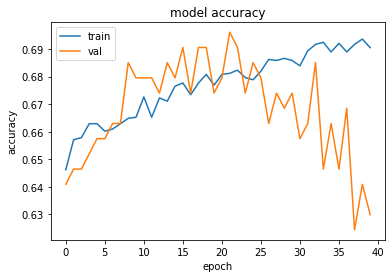

In [307]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

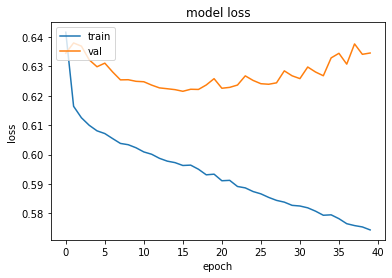

In [308]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [583]:
import lightgbm
print(lightgbm.__version__)
from lightgbm import LGBMClassifier

3.2.1


In [422]:
model = LGBMClassifier(n_estimators=100,learning_rate=0.1,max_depth=5,min_child_samples=5,max_bin=55)

In [424]:
fl = fbetl.feat_l.copy()
print(fl[:-0])

for i,f in enumerate(fl):
    fbetl.feat_l = fl[:(i+1)]
    print(fbetl.feat_l)
    model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
    model = LGBMClassifier(n_estimators=100,learning_rate=0.1,max_depth=5,min_child_samples=5,max_bin=255,random_state=123456)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, 2019, -8, True)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                      quant_tr=False, scaler=scaler, pca=None, qt=None, prob=False)
    print(fbetl.model_evaluate(y_test, predicted_l, verbose=False, prob=False, threshold=0.6))

[]
['CAvgH']
[2015 2016 2017 2018] 2019
(0.6795580110497238, 0.6761904761904762, 0.7473684210526316)
['CAvgH', 'CAvgD']
[2015 2016 2017 2018] 2019
(0.6740331491712708, 0.6666666666666666, 0.7578947368421053)
['CAvgH', 'CAvgD', 'CAvgA']
[2015 2016 2017 2018] 2019
(0.6298342541436464, 0.6346153846153846, 0.6947368421052632)
['CAvgH', 'CAvgD', 'CAvgA', 'CstdH']
[2015 2016 2017 2018] 2019
(0.6795580110497238, 0.6761904761904762, 0.7473684210526316)
['CAvgH', 'CAvgD', 'CAvgA', 'CstdH', 'CstdD']
[2015 2016 2017 2018] 2019
(0.6519337016574586, 0.6509433962264151, 0.7263157894736842)
['CAvgH', 'CAvgD', 'CAvgA', 'CstdH', 'CstdD', 'CstdA']
[2015 2016 2017 2018] 2019
(0.6187845303867403, 0.625, 0.6842105263157895)
['CAvgH', 'CAvgD', 'CAvgA', 'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad']
[2015 2016 2017 2018] 2019
(0.6464088397790055, 0.6422018348623854, 0.7368421052631579)
['CAvgH', 'CAvgD', 'CAvgA', 'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad', 'HomeTeamAge']
[2015 2016 2017 2018] 2019
(0.6464088397

In [60]:
model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
# model = svm.SVC(kernel='rbf',random_state=5756,probability=True)

In [61]:
model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)

In [62]:
predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=None, qt=None, prob=False)

In [63]:
X_test_odds

,B365H,B365A,B365D,HomeTeam,AwayTeam,Date
518,7.50,1.50,4.50,Cardiff,Tottenham,2019-01-01
103,2.00,4.20,3.50,Everton,Leicester,2019-01-01
2581,1.33,9.50,5.75,Arsenal,Fulham,2019-01-01
835,6.00,1.61,4.20,Newcastle,Man United,2019-01-02
1067,2.00,4.33,3.40,Wolves,Crystal Palace,2019-01-02
...,...,...,...,...,...,...
2623,1.28,11.00,6.50,Man United,Cardiff,2019-05-12
2464,1.44,8.50,4.75,Southampton,Huddersfield,2019-05-12
1806,19.00,1.16,8.50,Brighton,Man City,2019-05-12
2784,1.90,3.80,4.20,Crystal Palace,Bournemouth,2019-05-12


In [64]:
predicted_l

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1], dtype=int64)

In [65]:
fbetl.model_evaluate(y_test, predicted_l, verbose=True, prob=False, threshold=0.6)

Mean accuracy score: 0.672
Precision score: 0.66
Recall score: 0.711
confusion matrix: [[57 33]
 [26 64]]


(0.6722222222222223, 0.6597938144329897, 0.7111111111111111)

In [66]:
predicted_pl = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=None, qt=None, prob=True)

In [67]:
fbetl.play_the_game(predicted_l, predicted_pl, X_test_odds, Y_test, 0, 100, 0.90, True)

odds home: 1.33
Date        2019-01-01 00:00:00
HomeTeam                Arsenal
AwayTeam                 Fulham
Name: 2581, dtype: object
current profit: 33.0
odds away: 1.3 odds draw: 6.0
ratio draw: 0.17808219178082194 ratio away: 0.8219178082191781
Date        2019-01-12 00:00:00
HomeTeam               Brighton
AwayTeam              Liverpool
Name: 1946, dtype: object
current profit: 39.84931506849318
odds home: 1.22
Date        2019-01-29 00:00:00
HomeTeam                Arsenal
AwayTeam                Cardiff
Name: 2624, dtype: object
current profit: 61.84931506849318
odds away: 1.6 odds draw: 4.4
ratio draw: 0.26666666666666666 ratio away: 0.7333333333333334
Date        2019-02-09 00:00:00
HomeTeam           Huddersfield
AwayTeam                Arsenal
Name: 1409, dtype: object
current profit: 79.18264840182655


(79.18264840182655, 4, 4, 0)

In [ ]:
# predicted_pl = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
#                                   quant_tr=False, scaler=scaler, pca=None, qt=None, prob=True)

In [ ]:
pred_eval = []
for t in zip(predicted_pl,y_test):
    pred_eval.append([t[0][0],t[0][1], t[1]])

In [ ]:
pred_eval_df = pd.DataFrame(pred_eval,columns=['0prob','1prob','y_true'])

In [ ]:
pred_eval_df['pred'] = 0
pred_eval_df.loc[pred_eval_df['1prob'] >= 0.9,'pred']=1

In [ ]:
pred_eval_df[(pred_eval_df['1prob'] >= 0.9) | (pred_eval_df['0prob'] >= 0.9)]

In [ ]:
fbetl.model_evaluate(pred_eval_df.loc[(pred_eval_df['1prob'] >= 0.9) | (pred_eval_df['0prob'] >= 0.9)]['y_true'], 
                     pred_eval_df.loc[(pred_eval_df['1prob'] >= 0.9) | (pred_eval_df['0prob'] >= 0.9)]['pred'], 
                     verbose=True, prob=False, threshold=0.6)

In [628]:
fb_games_m_df[['CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue','Club_code_H', 'Club_code_A','AwayTeamP','HomeTeamP','MatchR','MatchAvgR','FTR_i']].corr()

,CAvgH,CAvgD,CAvgA,CstdH,CstdD,CstdA,HomeTeamSquad,HomeTeamAge,HomeTeamTmarketvalue,AwayTeamSquad,AwayTeamAge,AwayTeamTmarketvalue,AwayTeamP,HomeTeamP,MatchR,MatchAvgR,FTR_i
CAvgH,1.000000,0.056506,-0.487094,0.872478,-0.033493,-0.349706,-0.056217,0.214285,-0.321869,0.119964,-0.299644,0.665209,0.345538,-0.182952,-0.676135,-0.429569,0.298446
CAvgD,0.056506,1.000000,0.825294,0.154594,0.786022,0.782502,0.085221,-0.218769,0.590562,-0.005226,0.052157,0.062497,0.006115,0.279072,0.347518,0.225120,-0.195906
CAvgA,-0.487094,0.825294,1.000000,-0.316824,0.720346,0.904136,0.109844,-0.287733,0.636703,-0.065808,0.232201,-0.355131,-0.198303,0.325002,0.666449,0.429376,-0.329645
CstdH,0.872478,0.154594,-0.316824,1.000000,0.089592,-0.214169,-0.024804,0.169675,-0.243217,0.084462,-0.223220,0.482131,0.270304,-0.128489,-0.516030,-0.302073,0.212623
CstdD,-0.033493,0.786022,0.720346,0.089592,1.000000,0.780210,0.092292,-0.197278,0.333772,0.032081,0.050611,-0.116140,-0.031887,0.220760,0.323393,0.188034,-0.179023
CstdA,-0.349706,0.782502,0.904136,-0.214169,0.780210,1.000000,0.084846,-0.226278,0.493501,-0.036396,0.182178,-0.283965,-0.156927,0.264002,0.540762,0.338290,-0.269982
HomeTeamSquad,-0.056217,0.085221,0.109844,-0.024804,0.092292,0.084846,1.000000,-0.500287,0.165883,0.271197,-0.109683,-0.051464,0.075322,0.139631,0.066303,0.080336,-0.039823
HomeTeamAge,0.214285,-0.218769,-0.287733,0.169675,-0.197278,-0.226278,-0.500287,1.000000,-0.386301,-0.114626,0.044396,0.014393,-0.025397,-0.206192,-0.218076,-0.144721,0.111972
HomeTeamTmarketvalue,-0.321869,0.590562,0.636703,-0.243217,0.333772,0.493501,0.165883,-0.386301,1.000000,-0.051515,0.019071,0.169101,0.001620,0.366949,0.459911,0.326593,-0.247155
AwayTeamSquad,0.119964,-0.005226,-0.065808,0.084462,0.032081,-0.036396,0.271197,-0.114626,-0.051515,1.000000,-0.498846,0.164024,0.138322,0.074189,-0.064977,-0.078297,0.027436


In [ ]:
dat_l = fb_games_m_df[(fb_games_m_df['FYear'] == 2019) & (fb_games_m_df['Year'] == 2020)]['Date'].unique()
trail_pred = []

In [ ]:
# y_test  = fb_games_m_df[(fb_games_m_df['FYear'] == 2019) & (fb_games_m_df['Date']>=dat_l[0])]['FTR_i']
# X_test  = fb_games_m_df[(fb_games_m_df['FYear'] == 2019) & (fb_games_m_df['Date']>=dat_l[0])][fbetl.feat_l]
# X_train = fb_games_m_df[(fb_games_m_df['FYear'] == 2019) & (fb_games_m_df['Date']<dat_l[0])][fbetl.feat_l]
# y_train  = fb_games_m_df[(fb_games_m_df['FYear'] == 2019) & (fb_games_m_df['Date']<dat_l[0])]['FTR_i']

In [ ]:
for dat in dat_l:
    y_test  = fb_games_m_df[(fb_games_m_df['FYear'] == 2019) & (fb_games_m_df['Date']==dat)]['FTR_i']
    X_test  = fb_games_m_df[(fb_games_m_df['FYear'] == 2019) & (fb_games_m_df['Date']==dat)][fbetl.feat_l]
    X_train = fb_games_m_df[(fb_games_m_df['FYear'] == 2019) & (fb_games_m_df['Date']<dat)][fbetl.feat_l]
    y_train  = fb_games_m_df[(fb_games_m_df['FYear'] == 2019) & (fb_games_m_df['Date']<dat)]['FTR_i']
    
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=None, qt=None, prob=False)
#     print(len(predicted_l))
    trail_pred.extend(predicted_l)
print(len(trail_pred))

In [ ]:
len(trail_pred)

In [ ]:
X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, 2019, -8, True)

In [ ]:
fbetl.model_evaluate(y_test, trail_pred, verbose=True, prob=False, threshold=0.6)

In [ ]:
fb_games_m_df[['FTR','FTR_i']]

In [397]:
fbetl.feat_l = ['CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 
                'HomeTeamR', 'AwayTeamR', 'MatchR', 'ClubHR', 'ClubAR']

In [629]:
fbetl.feat_l 

['CAvgH',
 'CAvgD',
 'CAvgA',
 'CstdH',
 'CstdD',
 'CstdA',
 'HomeTeamSquad',
 'HomeTeamAge',
 'HomeTeamTmarketvalue',
 'AwayTeamSquad',
 'AwayTeamAge',
 'AwayTeamTmarketvalue',
 'HomeTeamP',
 'AwayTeamP',
 'HomeTeamAvgR',
 'AwayTeamAvgR',
 'HomeTeamR',
 'AwayTeamR',
 'ClubHR',
 'ClubAR',
 'MatchR',
 'MatchAvgR',
 'Club_code_H',
 'Club_code_A']

In [747]:
fbetl.feat_l = ['CAvgH',
 'CAvgD',
 'CAvgA',
 'CstdH',
 'CstdD',
 'CstdA',
 'HomeTeamSquad',
 'HomeTeamAge',
 'HomeTeamTmarketvalue',
 'AwayTeamSquad',
 'AwayTeamAge',
 'AwayTeamTmarketvalue',
 'HomeTeamP',
 'AwayTeamP',
 'HomeTeamAvgR',
 'AwayTeamAvgR',
 'HomeTeamR',
 'AwayTeamR',
 'ClubHR',
 'ClubAR',
 'MatchR',
 'MatchAvgR']

In [495]:
fbetl.feat_l = ['CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue','AwayTeamP','HomeTeamP','HomeTeamR','AwayTeamR','MatchR']

In [742]:
pthres = 0.9
for year in fb_games_m_df.FYear.unique()[:]:
    print(year)
#     model = RandomForestClassifier(n_estimators=150, oob_score=True, random_state=123456)
    model = XGBClassifier(n_estimators=150,use_label_encoder=False, random_state=123456,
                                                   max_depth=4, min_child_weight=2, eta=0.11,
                                                   subsample=1,reg_lambda=1,
                                                   colsample_bytree=1, eval_metric='logloss')
#     model = LGBMClassifier(n_estimators=80,learning_rate=0.15,max_depth=5,min_child_samples=50,max_bin=255,
#                            min_child_weight=2)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    print(fbetl.model_evaluate(y_test, predicted_l, verbose=False, prob=False, threshold=0.6))
    predicted_l = fbetl.model_predict(model, X_train, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    print(fbetl.model_evaluate(y_train, predicted_l, verbose=False, prob=False, threshold=0.6))
    
#     pred_eval = []
#     for t in zip(predicted_prob_l,y_test):
#         pred_eval.append([t[0][0],t[0][1], t[1]])
#     pred_eval_df = pd.DataFrame(pred_eval,columns=['0prob','1prob','y_true'])
#     pred_eval_df['pred'] = 0
#     pred_eval_df.loc[pred_eval_df['1prob'] >= pthres,'pred']=1
#     print(fbetl.model_evaluate(pred_eval_df.loc[(pred_eval_df['1prob'] >= 0.9) | (pred_eval_df['0prob'] >= 0.9)]['y_true'], 
#                      pred_eval_df.loc[(pred_eval_df['1prob'] >= 0.9) | (pred_eval_df['0prob'] >= 0.9)]['pred'], 
#                      verbose=True, prob=False, threshold=0.6))
#     print(fbetl.play_the_game(predicted_l, predicted_prob_l, X_test_odds, Y_test, 0, 100, pthres, False))

2012
(0.6335877862595419, 0.6666666666666666, 0.7027027027027027)
(1.0, 1.0, 1.0)
2013
(0.6143790849673203, 0.5841584158415841, 0.7763157894736842)
(0.9952941176470588, 0.9958333333333333, 0.9958333333333333)
2014
(0.5955882352941176, 0.618421052631579, 0.6438356164383562)
(0.9789915966386554, 0.9682926829268292, 0.9949874686716792)
2015
(0.5789473684210527, 0.6226415094339622, 0.6226415094339622)
(0.95, 0.939443535188216, 0.9745331069609507)
2016
(0.609375, 0.6, 0.65625)
(0.9273624823695346, 0.9216646266829865, 0.9507575757575758)
2017
(0.5906432748538012, 0.6086956521739131, 0.6222222222222222)
(0.8911489829576691, 0.8810198300283286, 0.9283582089552239)
2018
(0.6111111111111112, 0.6, 0.6666666666666666)
(0.8689497716894977, 0.861878453038674, 0.9069767441860465)
2019
(0.6629834254143646, 0.6574074074074074, 0.7473684210526316)
(0.8505254963020631, 0.8354098360655737, 0.9054726368159204)
2020
(0.6755555555555556, 0.768595041322314, 0.6739130434782609)
(0.8292598967297763, 0.819075144

In [181]:
2015
(0.6157894736842106, 0.6434782608695652, 0.6981132075471698)
2016
(0.6302083333333334, 0.6506024096385542, 0.5625)
2017
(0.6081871345029239, 0.6292134831460674, 0.6222222222222222)
2018
(0.6388888888888888, 0.6506024096385542, 0.6)
2019
(0.6906077348066298, 0.672566371681416, 0.8)
2020
(0.64, 0.7394957983193278, 0.6376811594202898)
2021
(0.6700507614213198, 0.6949152542372882, 0.7387387387387387)
2022
(0.7391304347826086, 0.75, 0.75)

(0.7391304347826086, 0.75, 0.75)

In [746]:
pthres = 0.8
for year in fb_games_m_df.FYear.unique()[:]:
    print(year)
    model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
    model = XGBClassifier(n_estimators=150,use_label_encoder=False, random_state=123,
                                                   max_depth=4, min_child_weight=2, eta=0.11,
                                                   subsample=1,reg_lambda=1,
                                                   colsample_bytree=1, eval_metric='logloss')
#     model = LGBMClassifier(n_estimators=80,learning_rate=0.15,max_depth=5,min_child_samples=50,max_bin=255,
#                            min_child_weight=2,random_state=12345)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -20, True)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
#     print(fbetl.model_evaluate(y_test, predicted_l, verbose=True, prob=False, threshold=0.6))
    pred_eval = []
    for t in zip(predicted_prob_l,y_test):
        pred_eval.append([t[0][0],t[0][1], t[1]])
    pred_eval_df = pd.DataFrame(pred_eval,columns=['0prob','1prob','y_true'])
    pred_eval_df['pred'] = 0
    pred_eval_df.loc[pred_eval_df['1prob'] >= pthres,'pred']=1
#     print(fbetl.model_evaluate(pred_eval_df.loc[(pred_eval_df['1prob'] >= 0.9) | (pred_eval_df['0prob'] >= 0.9)]['y_true'], 
#                      pred_eval_df.loc[(pred_eval_df['1prob'] >= 0.9) | (pred_eval_df['0prob'] >= 0.9)]['pred'], 
#                      verbose=True, prob=False, threshold=0.6))
    print(fbetl.play_the_game(predicted_l, predicted_prob_l, X_test_odds, Y_test, 2, 100, pthres, False))

2012
[] 2012
(-257.08031474370927, 43, 25, 18)
2013
[2012] 2013
(-990.3500532395478, 39, 19, 20)
2014
[2012 2013] 2014
(-336.1708368811987, 24, 13, 11)
2015
[2012 2013 2014] 2015
(-268.60722218568736, 21, 11, 10)
2016
[2012 2013 2014 2015] 2016
(-70.68322981366461, 4, 2, 2)
2017
[2012 2013 2014 2015 2016] 2017
(-107.5816816133347, 10, 6, 4)
2018
[2012 2013 2014 2015 2016 2017] 2018
(-78.62231182795699, 5, 3, 2)
2019
[2012 2013 2014 2015 2016 2017 2018] 2019
(109.80917500489875, 8, 6, 2)
2020
[2012 2013 2014 2015 2016 2017 2018 2019] 2020
(134.90854882238804, 9, 7, 2)
2021
[2012 2013 2014 2015 2016 2017 2018 2019 2020] 2021
(155.81341199783822, 6, 5, 1)
2022
[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021] 2022
(102.36914379326402, 3, 3, 0)


In [249]:
import pickle
savefile = 'saved_models/epl_xb_extraf_20230215'
pickle.dump(model, open(savefile+'.model', 'wb'))
pickle.dump(scaler, open(savefile + '.scaler', 'wb'))
pickle.dump(pca, open(savefile + '.pca', 'wb'))

In [250]:
stand_df.to_pickle('epl_stand.pckl')
mvalue_df.to_pickle('epl_mvalue.pckl')

In [232]:
import matplotlib.pylab as plt
import seaborn as sns

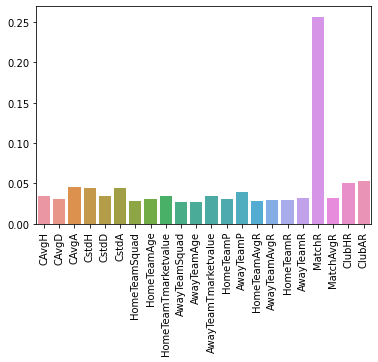

In [233]:
sns.barplot(fbetl.feat_l, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [760]:
fb_games_m_df.columns

Index(['FYear', 'Year', 'Month', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'B365H', 'B365A', 'B365D', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'ClubHR', 'ClubAR', 'MatchR',
       'MatchAvgR', 'FTR_i', 'FTR_a', 'Club_code_H', 'Club_code_A'],
      dtype='object')

In [767]:
fbetl.feat_l = ['CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'B365H', 'B365A', 'B365D', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'ClubHR', 'ClubAR', 'MatchR',
       'MatchAvgR','Club_code_H', 'Club_code_A']

In [786]:
### Parameter Search RF
year = 2020
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 5, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 87, 125, 162, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 3, 4, 5, None], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [769]:
X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False) 
print(year)
ac = 0
for g in ParameterGrid(random_grid):
    model = RandomForestClassifier(**g)
    
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    ev = fbetl.model_evaluate(y_test, predicted_l, verbose=False, prob=False, threshold=0.6)
    if ev[0] > ac:
        ac = ev[0]
        best_grid = g
        print(ac)
        print(g)

2020
0.7022222222222222
{'bootstrap': True, 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.7066666666666667
{'bootstrap': True, 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 77}
0.7111111111111111
{'bootstrap': True, 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.7244444444444444
{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


In [ ]:
best_grid

In [773]:
for year in fb_games_m_df.FYear.unique()[:]:
    print(year)
    model = RandomForestClassifier(**best_grid)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    print(fbetl.model_evaluate(y_test, predicted_l, verbose=False, prob=False, threshold=0.6))
    predicted_l = fbetl.model_predict(model, X_train, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    print(fbetl.model_evaluate(y_train, predicted_l, verbose=False, prob=False, threshold=0.6))

2012
(0.648854961832061, 0.6555555555555556, 0.7972972972972973)
(0.9716312056737588, 0.9523809523809523, 1.0)
2013
(0.5947712418300654, 0.5648148148148148, 0.8026315789473685)
(0.9835294117647059, 0.9794238683127572, 0.9916666666666667)
2014
(0.5955882352941176, 0.6071428571428571, 0.6986301369863014)
(0.9831932773109243, 0.9801488833746899, 0.9899749373433584)
2015
(0.6263157894736842, 0.6446280991735537, 0.7358490566037735)
(0.9846153846153847, 0.9815126050420168, 0.9915110356536503)
2016
(0.6145833333333334, 0.61, 0.6354166666666666)
(0.9908321579689704, 0.9887076537013801, 0.9949494949494949)
2017
(0.6491228070175439, 0.6704545454545454, 0.6555555555555556)
(0.9851566794942276, 0.9794117647058823, 0.9940298507462687)
2018
(0.5888888888888889, 0.5816326530612245, 0.6333333333333333)
(0.9872146118721461, 0.9851485148514851, 0.9916943521594684)
2019
(0.6519337016574586, 0.635593220338983, 0.7894736842105263)
(0.9898793304787855, 0.9893692416725727, 0.992181947405828)
2020
(0.64444444

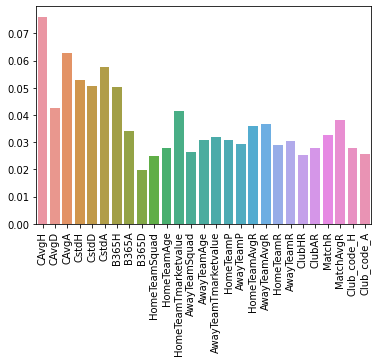

In [775]:
sns.barplot(fbetl.feat_l, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [808]:
 # Create parameters to search LGBM
# n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 10)]
grid_params = {'learning_rate': [0.05, 0.1, 0.12, 0.15, 0.2], 'n_estimators': [100],
                   'num_leaves': [4, 6, 8], 'boosting_type': ['gbdt'], 
                   'max_depth':max_depth, 'min_child_weight':[1,2,3],
                   'objective': ['binary'], 'seed': [500],
                   'colsample_bytree': [0.75, 0.8, 1], 
                   'subsample': [0.75, 1], 'reg_alpha': [1, 2, 6],
                   'reg_lambda': [1, 2, 6]}

In [809]:
grid_params

{'learning_rate': [0.05, 0.1, 0.12, 0.15, 0.2],
 'n_estimators': [100],
 'num_leaves': [4, 6, 8],
 'boosting_type': ['gbdt'],
 'max_depth': [1, 2, 3, 4, 5, None],
 'min_child_weight': [1, 2, 3],
 'objective': ['binary'],
 'seed': [500],
 'colsample_bytree': [0.75, 0.8, 1],
 'subsample': [0.75, 1],
 'reg_alpha': [1, 2, 6],
 'reg_lambda': [1, 2, 6]}

In [810]:
year = 2020
X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False) 
print(year)
ac = 0
for g in ParameterGrid(grid_params):
    model = LGBMClassifier(**g)
    
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    ev = fbetl.model_evaluate(y_test, predicted_l, verbose=False, prob=False, threshold=0.6)
    if ev[0] > ac:
        ac = ev[0]
        best_grid = g
        print(ac)
        print(g)

2020
0.6844444444444444
{'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'num_leaves': 4, 'objective': 'binary', 'reg_alpha': 1, 'reg_lambda': 1, 'seed': 500, 'subsample': 0.75}
0.6888888888888889
{'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'num_leaves': 4, 'objective': 'binary', 'reg_alpha': 1, 'reg_lambda': 6, 'seed': 500, 'subsample': 0.75}
0.7022222222222222
{'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'num_leaves': 4, 'objective': 'binary', 'reg_alpha': 1, 'reg_lambda': 1, 'seed': 500, 'subsample': 0.75}
0.7066666666666667
{'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'num_leaves': 4, 'objective': 'binary', 'reg_alpha': 1, 'reg_lam

KeyboardInterrupt: 

In [1547]:
best_grid = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 50,
 'num_leaves': 8,
 'objective': 'binary',
 'reg_alpha': 2,
 'reg_lambda': 6,
 'seed': 500,
 'subsample': 0.75}

In [1499]:
for year in fb_games_m_df.FYear.unique()[:]:
    print(year)
    model = LGBMClassifier(**best_grid)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    print(fbetl.model_evaluate(y_test, predicted_l, verbose=False, prob=False, threshold=0.6))
    predicted_l = fbetl.model_predict(model, X_train, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    print(fbetl.model_evaluate(y_train, predicted_l, verbose=False, prob=False, threshold=0.6))

2012
(0.6106870229007634, 0.6095238095238096, 0.8648648648648649)
(0.7801418439716312, 0.7578947368421053, 0.9)
2013
(0.6601307189542484, 0.6071428571428571, 0.8947368421052632)
(0.7741176470588236, 0.7448979591836735, 0.9125)
2014
(0.6029411764705882, 0.6144578313253012, 0.6986301369863014)
(0.7563025210084033, 0.7378435517970402, 0.87468671679198)
2015
(0.6421052631578947, 0.6610169491525424, 0.7358490566037735)
(0.7221153846153846, 0.7066115702479339, 0.8709677419354839)
2016
(0.671875, 0.6633663366336634, 0.6979166666666666)
(0.7016925246826516, 0.6994594594594594, 0.8169191919191919)
2017
(0.6257309941520468, 0.6511627906976745, 0.6222222222222222)
(0.7091808686091259, 0.7121212121212122, 0.7950248756218905)
2018
(0.65, 0.6336633663366337, 0.7111111111111111)
(0.7059360730593607, 0.7002861230329042, 0.8131229235880398)
2019
(0.6685082872928176, 0.6495726495726496, 0.8)
(0.6963799143635656, 0.6908094948265369, 0.806680881307747)
2020
(0.6977777777777778, 0.75, 0.7608695652173914)
(

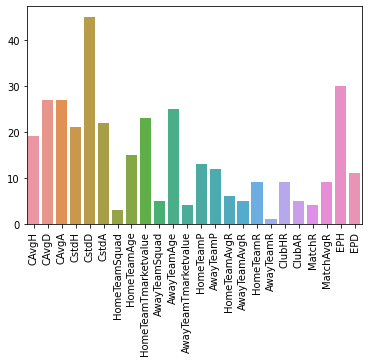

In [1498]:
sns.barplot(fbetl.feat_l, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [1556]:
pthres = 0.7
for year in fb_games_m_df.FYear.unique()[5:]:
    print(year)
    
    model = LGBMClassifier(**best_grid)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -20, True)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    print(play_the_game(predicted_l, predicted_prob_l, X_test_odds, Y_test, 2, 100, pthres, False,True))

2017
[2012 2013 2014 2015 2016] 2017
(86.09690188828733, 6, 4, 2)
2018
[2012 2013 2014 2015 2016 2017] 2018
(22.561754684838178, 3, 2, 1)
2019
[2012 2013 2014 2015 2016 2017 2018] 2019
(0, 0, 0, 0)
2020
[2012 2013 2014 2015 2016 2017 2018 2019] 2020
(-262.03389830508473, 3, 1, 2)
2021
[2012 2013 2014 2015 2016 2017 2018 2019 2020] 2021
(113.73172777378383, 2, 2, 0)
2022
[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021] 2022
(32.63157894736841, 1, 1, 0)


In [820]:
### XGBoost Grid Search

In [961]:
# A parameter grid for XGBoost
x_params = {
        'min_child_weight': [1, 2, 3, 4, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6],
        'eval_metric':['logloss'],
        'eta': [0.05, 0.1, 0.15],
        'n_estimators':[50, 100, 150], 'use_label_encoder':[False], 'random_state':[123]
        }

In [962]:
year = 2020
X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False) 
print(year)
ac = 0
for g in ParameterGrid(x_params):
    model = XGBClassifier(**g)
    
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    ev = fbetl.model_evaluate(y_test, predicted_l, verbose=False, prob=False, threshold=0.6)
    if ev[0] > ac:
        ac = ev[0]
        best_grid = g
        print(ac)
        print(g)

2020
0.7022222222222222
{'colsample_bytree': 0.6, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 150, 'random_state': 123, 'subsample': 0.6, 'use_label_encoder': False}
0.7155555555555555
{'colsample_bytree': 0.6, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 150, 'random_state': 123, 'subsample': 0.8, 'use_label_encoder': False}


KeyboardInterrupt: 

In [1540]:
best_grid = {'colsample_bytree': 0.6,
 'eta': 0.05,
 'eval_metric': 'logloss',
 'gamma': 0.5,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 100,
 'random_state': 123,
 'subsample': 0.8,
 'use_label_encoder': False}

In [1541]:
best_grid['min_child_weight'] = 2
best_grid['colsample_bytree'] = 0.8

In [1542]:
for year in fb_games_m_df.FYear.unique()[:]:
    print(year)
    model = XGBClassifier(**best_grid)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    print(fbetl.model_evaluate(y_test, predicted_l, verbose=False, prob=False, threshold=0.6))
    predicted_l = fbetl.model_predict(model, X_train, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    print(fbetl.model_evaluate(y_train, predicted_l, verbose=False, prob=False, threshold=0.6))

2012
(0.6793893129770993, 0.6702127659574468, 0.8513513513513513)
(0.9148936170212766, 0.9047619047619048, 0.95)
2013
(0.6013071895424836, 0.5757575757575758, 0.75)
(0.8682352941176471, 0.8484848484848485, 0.9333333333333333)
2014
(0.5955882352941176, 0.6125, 0.6712328767123288)
(0.8053221288515406, 0.7901785714285714, 0.8872180451127819)
2015
(0.6473684210526316, 0.6788990825688074, 0.6981132075471698)
(0.7769230769230769, 0.7575757575757576, 0.8913412563667232)
2016
(0.6666666666666666, 0.6538461538461539, 0.7083333333333334)
(0.7383638928067701, 0.7300546448087432, 0.8434343434343434)
2017
(0.6549707602339181, 0.6781609195402298, 0.6555555555555556)
(0.7498625618471688, 0.7420774647887324, 0.8388059701492537)
2018
(0.6055555555555555, 0.5979381443298969, 0.6444444444444445)
(0.7342465753424657, 0.7280058651026393, 0.824750830564784)
2019
(0.6685082872928176, 0.6548672566371682, 0.7789473684210526)
(0.7224601012066952, 0.7149938042131351, 0.820184790334044)
2020
(0.6888888888888889, 

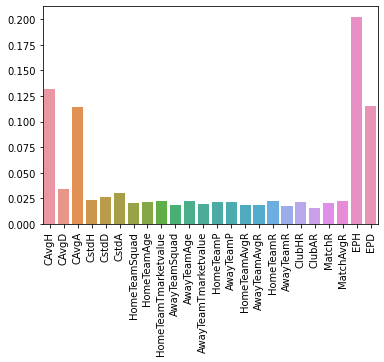

In [1494]:
sns.barplot(fbetl.feat_l, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [1546]:
pthres = 0.6
for year in fb_games_m_df.FYear.unique()[5:]:
    print(year)
    
    model = XGBClassifier(**best_grid)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -20, True)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    print(play_the_game(predicted_l, predicted_prob_l, X_test_odds, Y_test, 2, 100, pthres, False,True))

2017
[2012 2013 2014 2015 2016] 2017
(-2006.0134688694834, 27, 14, 13)
2018
[2012 2013 2014 2015 2016 2017] 2018
(-927.2361802615345, 27, 14, 13)
2019
[2012 2013 2014 2015 2016 2017 2018] 2019
(228.75395908225312, 36, 24, 12)
2020
[2012 2013 2014 2015 2016 2017 2018 2019] 2020
(396.049997551004, 52, 37, 15)
2021
[2012 2013 2014 2015 2016 2017 2018 2019 2020] 2021
(410.6393838271358, 54, 37, 17)
2022
[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021] 2022
(-723.7990881580786, 18, 11, 7)


In [1484]:
BATCH_SIZE = 128
EPOCHS = 80

In [1485]:
simple_model = Sequential()
simple_model.add(Dense(64, activation='relu', input_shape = (len(fbetl.feat_l),)))
# simple_model.add(Dropout(0.5))
simple_model.add(Dense(64, activation='relu'))
# simple_model.add(Dropout(0.5))
# simple_model.add(Dense(128, activation='relu'))
# simple_model.add(Dropout(0.5))
simple_model.add(Dense(64, activation='relu'))
# simple_model.add(Dropout(0.5))
simple_model.add(Dense(4, activation='relu'))
simple_model.add(Dense(1, activation='sigmoid'))
simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
simple_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 64)                1600      
_________________________________________________________________
dense_87 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_88 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_89 (Dense)             (None, 4)                 260       
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 5         
Total params: 10,185
Trainable params: 10,185
Non-trainable params: 0
_________________________________________________________________


In [1486]:
year = 2020
X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False) 

In [1487]:
scaler = fb_experiment.preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [1488]:
history = simple_model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/80
23/23 [==============================] - 1s 14ms/step - loss: 0.6432 - accuracy: 0.6289 - val_loss: 0.6026 - val_accuracy: 0.6489
Epoch 2/80
23/23 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6596 - val_loss: 0.6119 - val_accuracy: 0.6489
Epoch 3/80
23/23 [==============================] - 0s 4ms/step - loss: 0.6085 - accuracy: 0.6657 - val_loss: 0.6093 - val_accuracy: 0.6400
Epoch 4/80
23/23 [==============================] - 0s 4ms/step - loss: 0.6023 - accuracy: 0.6713 - val_loss: 0.6122 - val_accuracy: 0.6489
Epoch 5/80
23/23 [==============================] - 0s 4ms/step - loss: 0.5973 - accuracy: 0.6754 - val_loss: 0.6073 - val_accuracy: 0.6533
Epoch 6/80
23/23 [==============================] - 0s 4ms/step - loss: 0.5924 - accuracy: 0.6802 - val_loss: 0.6197 - val_accuracy: 0.6533
Epoch 7/80
23/23 [==============================] - 0s 4ms/step - loss: 0.5896 - accuracy: 0.6809 - val_loss: 0.6146 - val_accuracy: 0.6667
Epoch 8/80
23/23 [=

Epoch 59/80
23/23 [==============================] - 0s 4ms/step - loss: 0.2564 - accuracy: 0.9033 - val_loss: 0.9817 - val_accuracy: 0.5733
Epoch 60/80
23/23 [==============================] - 0s 4ms/step - loss: 0.2547 - accuracy: 0.9060 - val_loss: 0.9884 - val_accuracy: 0.5689
Epoch 61/80
23/23 [==============================] - 0s 4ms/step - loss: 0.2504 - accuracy: 0.9029 - val_loss: 0.9522 - val_accuracy: 0.5778
Epoch 62/80
23/23 [==============================] - 0s 4ms/step - loss: 0.2440 - accuracy: 0.9071 - val_loss: 1.0700 - val_accuracy: 0.5644
Epoch 63/80
23/23 [==============================] - 0s 4ms/step - loss: 0.2406 - accuracy: 0.9067 - val_loss: 1.0568 - val_accuracy: 0.5556
Epoch 64/80
23/23 [==============================] - 0s 4ms/step - loss: 0.2325 - accuracy: 0.9102 - val_loss: 1.1517 - val_accuracy: 0.5600
Epoch 65/80
23/23 [==============================] - 0s 4ms/step - loss: 0.2112 - accuracy: 0.9274 - val_loss: 1.0802 - val_accuracy: 0.5689
Epoch 66/80
2

In [1145]:
fbetl.feat_l

['CAvgH',
 'CAvgD',
 'CAvgA',
 'CstdH',
 'CstdD',
 'CstdA',
 'HomeTeamSquad',
 'HomeTeamAge',
 'HomeTeamTmarketvalue',
 'AwayTeamSquad',
 'AwayTeamAge',
 'AwayTeamTmarketvalue',
 'HomeTeamP',
 'AwayTeamP',
 'HomeTeamAvgR',
 'AwayTeamAvgR',
 'HomeTeamR',
 'AwayTeamR',
 'ClubHR',
 'ClubAR',
 'MatchR',
 'MatchAvgR']

In [1478]:
from catboost import CatBoostClassifier

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=2,
                           learning_rate=1,
                           depth=2)

In [1479]:
# A parameter grid for XGBoost
cat_params = {
        'iterations':[50,100],
        'depth':[1,2,3,4],
        'learning_rate':[0.05,0.1]
        }

In [1480]:
year = 2019
X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False) 
print(year)
ac = 0
for g in ParameterGrid(cat_params):
    model = CatBoostClassifier(**g,verbose=False)
    
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    ev = fbetl.model_evaluate(y_test, predicted_l, verbose=False, prob=False, threshold=0.6)
    if ev[0] > ac:
        ac = ev[0]
        best_grid = g
        print(ac)
        print(g)

2019
0.6629834254143646
{'depth': 1, 'iterations': 50, 'learning_rate': 0.05}
0.6795580110497238
{'depth': 1, 'iterations': 50, 'learning_rate': 0.1}
0.6850828729281768
{'depth': 1, 'iterations': 100, 'learning_rate': 0.1}


In [1150]:
for year in fb_games_m_df.FYear.unique()[:]:
    print(year)
    model = CatBoostClassifier(**best_grid,verbose=False)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    print(fbetl.model_evaluate(y_test, predicted_l, verbose=False, prob=False, threshold=0.6))
    predicted_l = fbetl.model_predict(model, X_train, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    print(fbetl.model_evaluate(y_train, predicted_l, verbose=False, prob=False, threshold=0.6))

2012
(0.6335877862595419, 0.6413043478260869, 0.7972972972972973)
(0.6737588652482269, 0.660377358490566, 0.875)
2013
(0.6209150326797386, 0.5789473684210527, 0.868421052631579)
(0.6729411764705883, 0.6613418530351438, 0.8625)
2014
(0.6176470588235294, 0.6082474226804123, 0.8082191780821918)
(0.6764705882352942, 0.6666666666666666, 0.8421052631578947)
2015
(0.6578947368421053, 0.6541353383458647, 0.8207547169811321)
(0.6567307692307692, 0.6542553191489362, 0.8353140916808149)
2016
(0.6354166666666666, 0.6015625, 0.8020833333333334)
(0.6488011283497884, 0.6509240246406571, 0.8005050505050505)
2017
(0.6257309941520468, 0.6120689655172413, 0.7888888888888889)
(0.6608026388125343, 0.6641285956006768, 0.7810945273631841)
2018
(0.6833333333333333, 0.6542056074766355, 0.7777777777777778)
(0.6625570776255708, 0.6676279740447008, 0.7691029900332226)
2019
(0.6906077348066298, 0.6695652173913044, 0.8105263157894737)
(0.6656286492798754, 0.672544080604534, 0.7590618336886994)
2020
(0.7066666666666

In [1482]:
pthres = 0.75
for year in fb_games_m_df.FYear.unique()[:]:
    print(year)
    
    model = CatBoostClassifier(**best_grid,verbose=False)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -20, True)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    print(play_the_game(predicted_l, predicted_prob_l, X_test_odds, Y_test, 0, 100, pthres, False))

2012
[] 2012
(31.10628029355624, 15, 11, 4)
2013
[2012] 2013
(-127.60541905535072, 39, 30, 9)
2014
[2012 2013] 2014
(-531.8972595715381, 30, 20, 10)
2015
[2012 2013 2014] 2015
(132.19264746426478, 24, 21, 3)
2016
[2012 2013 2014 2015] 2016
(-239.86524771719746, 50, 41, 9)
2017
[2012 2013 2014 2015 2016] 2017
(-451.6585335859374, 62, 49, 13)
2018
[2012 2013 2014 2015 2016 2017] 2018
(-201.85680247086523, 50, 42, 8)
2019
[2012 2013 2014 2015 2016 2017 2018] 2019
(-462.86073436697234, 48, 38, 10)
2020
[2012 2013 2014 2015 2016 2017 2018 2019] 2020
(-322.9597937453184, 51, 42, 9)
2021
[2012 2013 2014 2015 2016 2017 2018 2019 2020] 2021
(290.1972671701294, 46, 43, 3)
2022
[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021] 2022
(-82.88822943467773, 9, 7, 2)


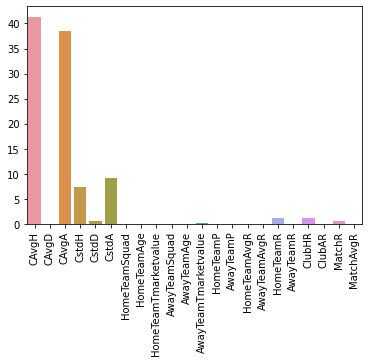

In [1154]:
sns.barplot(fbetl.feat_l, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [1397]:
import lightgbm as lgb

def custom_loss(y_pred, data, threshold=0.5):
    
    y_true = data.get_label()
    eph = data.data['EPH']
    epa = data.data['EPD']
    pred_away = (y_pred > threshold).astype(int)
    pred_home = (y_pred <= threshold).astype(int)
    
    profit = 0
    for i,j in enumerate(y_true):
        if (j == 0) & (pred_home[i]==1) :
            profit =  profit + eph.iloc[i]
        elif (j == 1) & (pred_away[i]==1) :
            profit =  profit + epa.iloc[i]
        else:
            profit = profit - 1
                
    # # eval_name, eval_result, is_higher_better
    return 'my_profit', profit, True

params = {"learning_rate" : 0.1,'n_estimators':10}

In [1011]:
X_train = X_train.drop(['Club_code_H','Club_code_A'],axis=1)

In [1024]:
fb_games_m_df

Index(['FYear', 'Year', 'Month', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'B365H', 'B365A', 'B365D', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'ClubHR', 'ClubAR', 'MatchR',
       'MatchAvgR', 'FTR_i', 'FTR_a', 'Club_code_H', 'Club_code_A'],
      dtype='object')

In [1025]:
for i in range(fb_games_m_df.shape[0]):

    odds_sum = fb_games_m_df.iloc[i]['B365A'] + fb_games_m_df.iloc[i]['B365D']
    ratio_draw = fb_games_m_df.iloc[i]['B365A'] / odds_sum
    ratio_away = fb_games_m_df.iloc[i]['B365D'] / odds_sum

                    
    if fb_games_m_df.iloc[i]['FTR'] == 'A':
        fb_games_m_df.loc[i,'FTPay'] = ratio_away * 1 * (fb_games_m_df.iloc[i]['B365A']) - 1
    elif fb_games_m_df.iloc[i]['FTR'] == 'D':
        fb_games_m_df.loc[i,'FTPay'] = ratio_draw * 1 * (fb_games_m_df.iloc[i]['B365D']) - 1
    else:
        fb_games_m_df.loc[i,'FTPay'] = fb_games_m_df.iloc[i]['B365H'] - 1

In [1026]:
fb_games_m_df

,FYear,Year,Month,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,AwayTeamR,ClubHR,ClubAR,MatchR,MatchAvgR,FTR_i,FTR_a,Club_code_H,Club_code_A,FTPay
0,2012,2012,8,2012-08-18,Arsenal,Sunderland,0,0,D,0,...,0,0,0,0,0.000000,1,-1,3,8,1.942308
574,2012,2012,8,2012-08-18,Newcastle,Tottenham,2,1,H,0,...,0,0,0,0,0.000000,0,0,6,4,0.285714
1378,2012,2012,8,2012-08-18,West Brom,Liverpool,3,0,H,1,...,0,0,0,0,0.000000,0,0,15,5,0.700000
1557,2012,2012,8,2012-08-18,Reading,Stoke,1,1,D,0,...,0,0,0,0,0.000000,1,-1,19,12,1.829787
1676,2012,2012,8,2012-08-18,West Ham,Aston Villa,1,0,H,1,...,0,0,0,0,0.000000,0,0,13,11,0.170000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2022,2023,2,2023-02-18,Chelsea,Southampton,0,1,A,0,...,-22,6,-13,23,1.314299,1,1,2,17,0.866667
2364,2022,2023,2,2023-02-18,Brentford,Crystal Palace,1,1,D,0,...,-10,13,-5,17,1.742050,1,-1,38,23,0.393333
1376,2022,2023,2,2023-02-18,Newcastle,Liverpool,0,2,A,0,...,8,13,-8,14,0.161947,1,1,6,5,1.200000
2623,2022,2023,2,2023-02-19,Man United,Leicester,3,0,H,1,...,-2,13,-4,12,0.001011,0,0,29,26,0.535008


In [1228]:
    def split_fyear(df, year, lookback, verbose=False):
        y_l = df['FYear'].unique()
        y_test = df[(df['FYear'] == year) & (df['Year'] == (year + 1))]['FTR_i']
        Y_test = df[(df['FYear'] == year) & (df['Year'] == (year + 1))][['FTR', 'FTR_i']]
        X_test = df[(df['FYear'] == year) & (df['Year'] == (year + 1))][fbetl.feat_l]
        X_test_odds = df[(df['FYear'] == year) & (df['Year'] == (year + 1))][['B365H', 'B365A', 'B365D',
                                                                              'HomeTeam', 'AwayTeam','Date']]
        y_test_p = df[(df['FYear'] == year) & (df['Year'] == (year + 1))]['FTPay']
        if verbose:
            print(y_l[:(np.where(y_l == np.int64(year))[0][0])][lookback:], year)

        X_train = df[df['FYear'].isin(y_l[:(np.where(y_l == np.int64(year))[0][0])][lookback:])][fbetl.feat_l].\
            append(df[(df['FYear'] == year) & (df['Year'] == year)][fbetl.feat_l])
        y_train = df[df['FYear'].isin(y_l[:(np.where(y_l == np.int64(year))[0][0])][lookback:])]['FTR_i'].\
            append(df[(df['FYear'] == year) & (df['Year'] == year)]['FTR_i'])
        y_train_p = df[df['FYear'].isin(y_l[:(np.where(y_l == np.int64(year))[0][0])][lookback:])]['FTPay'].\
            append(df[(df['FYear'] == year) & (df['Year'] == year)]['FTPay'])
        return X_train, y_train, y_train_p, X_test, y_test,y_test_p, Y_test, X_test_odds

In [1362]:
X_train, y_train, y_train_p, X_test, y_test,y_test_p, Y_test, X_test_odds = split_fyear(fb_games_m_df, 2019, -20, True)

[2012 2013 2014 2015 2016 2017 2018] 2019


In [1370]:
X_train

,CAvgH,CAvgD,CAvgA,CstdH,CstdD,CstdA,HomeTeamSquad,HomeTeamAge,HomeTeamTmarketvalue,AwayTeamSquad,...,HomeTeamAvgR,AwayTeamAvgR,HomeTeamR,AwayTeamR,ClubHR,ClubAR,MatchR,MatchAvgR,EPH,EPD
0,1.396,4.472,8.316,0.045056,0.284464,0.679912,42,24.0,296.90,37,...,0.000000,0.000000,0,0,0,0,0,0.000000,0.40,1.942308
1,2.570,3.274,2.764,0.120416,0.184065,0.047223,39,24.6,201.75,41,...,0.000000,0.000000,0,0,0,0,0,0.000000,1.50,0.520325
2,3.958,3.438,1.940,0.425229,0.131225,0.063640,32,26.0,93.00,41,...,0.000000,0.000000,0,0,0,0,0,0.000000,3.20,0.235675
3,2.396,3.264,3.012,0.008944,0.072319,0.216148,35,26.3,46.25,30,...,0.000000,0.000000,0,0,0,0,0,0.000000,1.38,0.586614
4,2.232,3.318,3.266,0.058052,0.105451,0.174011,39,25.6,103.00,33,...,0.000000,0.000000,0,0,0,0,0,0.000000,1.20,0.674627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,1.964,3.574,3.906,0.021909,0.073348,0.071972,36,24.4,210.75,33,...,-0.451884,-0.067828,-14,-4,-15,-4,-10,-0.384056,0.95,0.848649
2565,4.006,3.844,1.856,0.105736,0.043932,0.019494,38,26.5,303.60,32,...,-1.780847,0.295452,-10,23,-6,13,-33,-2.076299,3.00,0.245550
2566,2.850,3.726,2.342,0.030822,0.025100,0.045497,38,24.3,607.65,36,...,0.047231,-0.206511,-3,6,-1,5,-9,0.253742,1.87,0.425620
2567,1.176,7.590,15.322,0.011402,0.201246,0.461974,34,25.1,1050.00,34,...,2.241551,0.056269,29,6,16,4,23,2.185282,0.16,4.106383


In [1231]:
best_grid = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 1,
#  'n_estimators': 100,
 'num_leaves': 8,
 'objective': 'binary',
 "first_metric_only": True,
 'reg_alpha': 2,
 'reg_lambda': 6,
 'seed': 500,
 'subsample': 0.75}
FIT_PARAMS_LGB = {"num_boost_round": 1000, "early_stopping_rounds": 100, "verbose_eval":100,}

In [1350]:
fbetl.feat_l = ['CAvgH',
 'CAvgD',
 'CAvgA',
 'CstdH',
 'CstdD',
 'CstdA',
 'HomeTeamSquad',
 'HomeTeamAge',
 'HomeTeamTmarketvalue',
 'AwayTeamSquad',
 'AwayTeamAge',
 'AwayTeamTmarketvalue',
 'HomeTeamP',
 'AwayTeamP',
 'HomeTeamAvgR',
 'AwayTeamAvgR',
 'HomeTeamR',
 'AwayTeamR',
 'ClubHR',
 'ClubAR',
 'MatchR',
 'MatchAvgR','EPH','EPD']

In [1353]:
from sklearn import preprocessing
model = LGBMClassifier(best_grid)
scaler = preprocessing.StandardScaler().fit(X_train[fbetl.feat_l])
X_train = scaler.transform(X_train[fbetl.feat_l])

In [1354]:
X_test = scaler.transform(X_test[fbetl.feat_l])

In [1237]:
# training_data = lgb.Dataset(X_train , label = y_train)
lgb_tr = lgb.Dataset(data=X_train, label=y_train,weight=y_train_p)
lgb_val = lgb.Dataset(data=X_test, label=y_test,weight=y_test_p)
model = lgb.train(best_grid,
                  lgb_tr,
                  **FIT_PARAMS_LGB,
                  valid_names=['train', 'valid'], valid_sets=[lgb_tr, lgb_val],
                  fobj=None,
                  feval=custom_loss)

[LightGBM] [Info] Number of positive: 1407, number of negative: 1162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3313
[LightGBM] [Info] Number of data points in the train set: 2569, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433767 -> initscore=-0.266497
[LightGBM] [Info] Start training from score -0.266497
Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.541264	train's my_profit: 239.412	valid's binary_logloss: 0.5136	valid's my_profit: 16.9577
[200]	train's binary_logloss: 0.506886	train's my_profit: 530.757	valid's binary_logloss: 0.519255	valid's my_profit: 21.3702
Early stopping, best iteration is:
[118]	train's binary_logloss: 0.534214	train's my_profit: 303.501	valid's binary_logloss: 0.512778	valid's my_profit: 23.9285
Evaluated only: binary_logloss


In [1241]:
X_test.shape

(181, 22)

In [1242]:
model.predict(X_test)

array([0.26774383, 0.42953259, 0.12783548, 0.35316526, 0.39383321,
       0.73671766, 0.1945012 , 0.44656425, 0.45567844, 0.81599158,
       0.42159802, 0.50718649, 0.1407955 , 0.33580563, 0.1988987 ,
       0.66452782, 0.71105531, 0.73700979, 0.39093979, 0.08547287,
       0.27087057, 0.55936055, 0.47954983, 0.14047773, 0.59096291,
       0.75763613, 0.25690624, 0.42658062, 0.11462695, 0.70191458,
       0.64179578, 0.12788853, 0.52088732, 0.19167905, 0.41924798,
       0.43709389, 0.5755067 , 0.68353031, 0.68987499, 0.10898027,
       0.14108942, 0.36673684, 0.44846995, 0.49143215, 0.40685287,
       0.3955696 , 0.34134301, 0.7662718 , 0.40525717, 0.22817071,
       0.13224482, 0.50986846, 0.45573333, 0.47123458, 0.34343092,
       0.10626484, 0.50249193, 0.13836488, 0.69867493, 0.4445021 ,
       0.80199448, 0.4856996 , 0.55826254, 0.34720481, 0.44109634,
       0.11054503, 0.34944179, 0.46160881, 0.60665787, 0.45744431,
       0.77908247, 0.12121744, 0.13424385, 0.45788588, 0.36869

In [1243]:
predicted_prob_l = model.predict(X_test)

In [1244]:
predicted_prob_l0 = 1 - predicted_prob_l

In [1245]:
predicted_probs_l = [[i,j] for i,j in zip(predicted_prob_l0,predicted_prob_l)]

In [1450]:
best_grid = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 1,
#  'n_estimators': 100,
 'num_leaves': 5,
 'objective': 'binary',
 'reg_alpha': 2,
 'reg_lambda': 4,
 'seed': 500,
 'subsample': 0.9}
FIT_PARAMS_LGB = {"num_boost_round": 100}
FIT_PARAMS_LGB = {"num_boost_round": 1000, "early_stopping_rounds": 50, "verbose_eval":100,}

In [1389]:
lgb_tr = lgb.Dataset(data=X_train, label=y_train,free_raw_data=False).construct()

In [1396]:
lgb_tr.data['EPH']

0      -0.734080
1      -0.164729
2       0.715177
3      -0.226840
4      -0.320006
          ...   
2185   -0.770311
2186    0.999852
2187    0.249344
2188   -0.770311
2189    3.717208
Name: EPH, Length: 2190, dtype: float64

In [1388]:
X_train

,CAvgH,CAvgD,CAvgA,CstdH,CstdD,CstdA,HomeTeamSquad,HomeTeamAge,HomeTeamTmarketvalue,AwayTeamSquad,...,HomeTeamAvgR,AwayTeamAvgR,HomeTeamR,AwayTeamR,ClubHR,ClubAR,MatchR,MatchAvgR,EPH,EPD
0,-0.762882,0.454533,0.947507,-0.371902,0.444364,0.539960,0.807351,-1.520760,0.092885,-0.217464,...,0.008210,-0.002175,0.013046,-0.015178,-0.319763,0.324209,0.019634,0.007276,-0.734080,0.758713
1,-0.101209,-0.606730,-0.511833,-0.020074,-0.104594,-0.559465,0.191861,-0.958972,-0.316021,0.602944,...,0.008210,-0.002175,0.013046,-0.015178,-0.319763,0.324209,0.019634,0.007276,-0.164729,-0.509289
2,0.681077,-0.461448,-0.728420,1.402980,-0.393511,-0.530937,-1.244284,0.351865,-0.783373,0.602944,...,0.008210,-0.002175,0.013046,-0.015178,-0.319763,0.324209,0.019634,0.007276,0.715177,-0.763115
3,-0.199276,-0.615588,-0.446646,-0.540491,-0.715596,-0.265923,-0.628793,0.632759,-0.984281,-1.653178,...,0.008210,-0.002175,0.013046,-0.015178,-0.319763,0.324209,0.019634,0.007276,-0.226840,-0.450178
4,-0.291708,-0.567752,-0.379882,-0.311228,-0.534435,-0.339144,0.191861,-0.022660,-0.740398,-1.037872,...,0.008210,-0.002175,0.013046,-0.015178,-0.319763,0.324209,0.019634,0.007276,-0.320006,-0.371696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,-0.788808,0.987823,1.126244,-0.488876,-0.502645,0.721304,-0.833957,-0.209922,2.678685,0.397842,...,0.964142,-0.232144,1.706075,-0.156926,1.064193,0.194856,1.298781,0.838103,-0.770311,0.942263
2186,1.236792,-0.110647,-0.787824,0.211826,-0.505107,-0.570300,-0.423630,0.726390,0.058935,3.269269,...,0.212565,1.319427,-0.551297,1.473174,-0.697206,1.617739,-1.407106,-0.781455,0.999852,-0.818874
2187,0.303460,-0.507513,-0.648514,-0.297502,-0.464526,-0.596210,-1.039121,2.318122,-0.335360,-0.217464,...,-0.650950,-0.869014,-1.679984,-0.086052,-1.577906,0.453562,-1.111918,0.157263,0.249344,-0.686940
2188,-0.793317,1.099441,1.154106,-0.498734,0.335614,0.349911,-0.423630,-0.303553,2.244639,-0.217464,...,1.540249,0.739442,0.436303,-0.440422,0.309308,-0.710614,0.610010,0.556175,-0.770311,1.006637


In [1379]:
preprocessing.StandardScaler().fit(X_train)

StandardScaler()

In [1381]:
xt = scaler.transform(X_train)

In [1382]:
pd.DataFrame(xt,columns=fbetl.feat_l)

,CAvgH,CAvgD,CAvgA,CstdH,CstdD,CstdA,HomeTeamSquad,HomeTeamAge,HomeTeamTmarketvalue,AwayTeamSquad,...,HomeTeamAvgR,AwayTeamAvgR,HomeTeamR,AwayTeamR,ClubHR,ClubAR,MatchR,MatchAvgR,EPH,EPD
0,-0.703559,0.366443,0.891096,-0.344519,0.494070,0.523286,0.784836,-1.493908,-0.017896,-0.230790,...,0.005073,-0.001422,0.011499,-0.012252,-0.304609,0.317419,0.016496,0.004579,-0.680182,0.719643
1,-0.116023,-0.613628,-0.502646,-0.012613,-0.052688,-0.517109,0.174962,-0.933365,-0.390212,0.584471,...,0.005073,-0.001422,0.011499,-0.012252,-0.304609,0.317419,0.016496,0.004579,-0.170314,-0.503274
2,0.578612,-0.479461,-0.709499,1.329860,-0.340448,-0.490114,-1.248078,0.374568,-0.815745,0.584471,...,0.005073,-0.001422,0.011499,-0.012252,-0.304609,0.317419,0.016496,0.004579,0.617664,-0.748076
3,-0.203102,-0.621808,-0.440390,-0.503562,-0.661242,-0.239328,-0.638204,0.654839,-0.998675,-1.657497,...,0.005073,-0.001422,0.011499,-0.012252,-0.304609,0.317419,0.016496,0.004579,-0.225936,-0.446265
4,-0.285177,-0.577632,-0.376627,-0.287281,-0.480807,-0.308618,0.174962,0.000873,-0.776615,-1.046051,...,0.005073,-0.001422,0.011499,-0.012252,-0.304609,0.317419,0.016496,0.004579,-0.309369,-0.370573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,-0.419300,-0.368201,-0.215965,-0.446463,-0.655635,-0.476411,-0.434912,-1.120213,-0.354996,-1.046051,...,-0.820743,-0.124866,-0.930545,-0.281854,-2.102178,-0.184705,-0.451255,-0.489786,-0.425248,-0.220913
2565,0.602634,-0.147317,-0.730585,-0.077270,-0.815834,-0.562707,-0.028329,0.841687,0.008321,-1.249866,...,-3.249415,0.536290,-0.661389,1.537960,-1.023637,1.949321,-1.527082,-2.668074,0.524961,-0.739583
2566,0.024105,-0.243851,-0.608583,-0.407207,-0.918390,-0.519947,-0.028329,-1.213637,1.198051,-0.434605,...,0.091388,-0.377265,-0.190368,0.392151,-0.424447,0.945073,-0.404480,0.331201,0.001187,-0.584722
2567,-0.813660,2.917244,2.649842,-0.492739,0.040876,0.164909,-0.841495,-0.466246,2.928940,-0.842236,...,4.101495,0.100985,1.962874,0.392151,1.612797,0.819543,1.092323,2.817517,-0.791426,2.580766


In [1431]:
from sklearn.compose import ColumnTransformer 
# from sklearn.preprocessing import  StandarScaler 
# column_trans = ColumnTransformer(
#     [('scaler', StandardScaler(),2],
#     remainder='passthrough') 
# column_trans.fit_transform(X)

In [1433]:
ft = fbetl.feat_l.copy()

In [1436]:
# ft.remove('EPD')
# ft.remove('EPH')
ft

['CAvgH',
 'CAvgD',
 'CAvgA',
 'CstdH',
 'CstdD',
 'CstdA',
 'HomeTeamSquad',
 'HomeTeamAge',
 'HomeTeamTmarketvalue',
 'AwayTeamSquad',
 'AwayTeamAge',
 'AwayTeamTmarketvalue',
 'HomeTeamP',
 'AwayTeamP',
 'HomeTeamAvgR',
 'AwayTeamAvgR',
 'HomeTeamR',
 'AwayTeamR',
 'ClubHR',
 'ClubAR',
 'MatchR',
 'MatchAvgR']

In [1458]:
pthres = 0.5
for year in fb_games_m_df.FYear.unique()[6:]:
    print(year)
    
    X_train, y_train, y_train_p, X_test, y_test,y_test_p, Y_test, X_test_odds = split_fyear(fb_games_m_df, year, -3, True)
    ct = ColumnTransformer([
        ('sc', preprocessing.StandardScaler(), ft)
    ], remainder='passthrough')

    X_train = ct.fit_transform(X_train[fbetl.feat_l])
#     scaler = preprocessing.StandardScaler().fit(X_train[fbetl.feat_l])
#     X_train = scaler.transform(X_train[fbetl.feat_l])
    X_test = ct.transform(X_test[fbetl.feat_l])
    X_train = pd.DataFrame(X_train,columns=fbetl.feat_l)
    X_test = pd.DataFrame(X_test,columns=fbetl.feat_l)
    lgb_tr = lgb.Dataset(data=X_train, label=y_train,free_raw_data=False).construct()
    lgb_val = lgb.Dataset(data=X_test, label=y_test,free_raw_data=False).construct()
    model = lgb.train(best_grid,
                  lgb_tr,
                  **FIT_PARAMS_LGB,
                  fobj=None,
                  valid_names=['train', 'valid'], valid_sets=[lgb_tr, lgb_val],
                  feval=custom_loss)
    predicted_prob_l = model.predict(X_test)
    predicted_prob_l0 = 1 - predicted_prob_l
    predicted_l = (predicted_prob_l > 0.5).astype(int)
    predicted_probs_l = [[i,j] for i,j in zip(predicted_prob_l0,predicted_prob_l)] 
    print(play_the_game(predicted_l, predicted_probs_l, X_test_odds, Y_test, 0, 100, pthres, False))

2018
[2015 2016 2017] 2018
[LightGBM] [Info] Number of positive: 732, number of negative: 608
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3442
[LightGBM] [Info] Number of data points in the train set: 1340, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546269 -> initscore=0.185606
[LightGBM] [Info] Start training from score 0.185606
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's binary_logloss: 0.618788	train's my_profit: 34.9268	valid's binary_logloss: 0.639134	valid's my_profit: 1.5036
(150.35991323151828, 180, 124, 56)
2019
[2016 2017 2018] 2019
[LightGBM] [Info] Number of positive: 712, number of negative: 627
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise

In [1410]:
X_test[['EPH','EPD']]

,EPH,EPD
0,2.423229,-0.861805
1,-0.423525,-0.162621
2,-0.770311,1.329106
3,-0.112970,-0.474753
4,1.646842,-0.827157
...,...,...
175,-0.475284,-0.086015
176,-0.320006,-0.304484
177,-0.796191,1.778304
178,-0.785839,1.596964


In [1211]:
    threshold = 0.5
    y_true = Y_test['FTR_i']
    pred_away = (predicted_prob_l > threshold).astype(int)
    pred_home = (predicted_prob_l <= threshold).astype(int)
    
    profit = 0
    for i,j in enumerate(y_true):
        if (j == 0) & (pred_home[i]==1) :
            profit =  profit + y_train_p.iloc[i]
        elif (j == 1) & (pred_away[i]==1) :
            profit =  profit + y_train_p.iloc[i]
        else:
            profit = profit - 1

In [1213]:
profit

56.55815397879819

In [1271]:
print(play_the_game(predicted_l, predicted_probs_l, X_test_odds, Y_test, 0, 10, 0.8, False))

(262.8, 44, 14, 30)


In [1525]:
    def play_the_game( predicted_l, predicted_prob_l, X_test, Y_test, odds_thres, bet, threshold, verbose, doubling=False):
        profit = 0
        games_played = 0
        hit = 0
        miss = 0
        init_bet = bet
        for i in range(X_test.shape[0]):
            

            pred = predicted_l[i]
            pred_prob = predicted_prob_l[i]
            if (pred_prob[1] > threshold):
                if (X_test.iloc[i]['B365A'] > odds_thres) & (X_test.iloc[i]['B365D'] > odds_thres):
                    odds_sum = X_test.iloc[i]['B365A'] + X_test.iloc[i]['B365D']
                    ratio_draw = X_test.iloc[i]['B365A'] / odds_sum
                    ratio_away = X_test.iloc[i]['B365D'] / odds_sum

                    if verbose:
                        print('odds away:', X_test.iloc[i]['B365A'], 'odds draw:', X_test.iloc[i]['B365D'])
                        print('ratio draw:', ratio_draw, 'ratio away:', ratio_away)
                        print(X_test.iloc[i][['Date','HomeTeam', 'AwayTeam']], 'result',Y_test.iloc[i]['FTR'])

                    games_played = games_played + 1
                    if Y_test.iloc[i]['FTR'] == 'A':
                        hit = hit + 1
                        profit = profit + ratio_away * bet * (X_test.iloc[i]['B365A']) - bet
                        bet = init_bet
                    elif Y_test.iloc[i]['FTR'] == 'D':
                        hit = hit + 1
                        profit = profit + ratio_draw * bet * (X_test.iloc[i]['B365D']) - bet
                        bet = init_bet
                    else:
                        miss = miss + 1
                        profit = profit - bet
                        if doubling:
                            bet = 2*bet
                    if verbose:
                        print('current profit:', profit)

            elif (pred_prob[0] >= threshold):
                if X_test.iloc[i]['B365H'] > odds_thres:
                    if verbose:
                        print('odds home:', X_test.iloc[i]['B365H'])
                        print(X_test.iloc[i][['Date','HomeTeam', 'AwayTeam']],'result',Y_test.iloc[i]['FTR'])

                    games_played = games_played + 1
                    if Y_test.iloc[i]['FTR'] == 'H':
                        hit = hit + 1
                        profit = profit + bet * (X_test.iloc[i]['B365H']) - bet
                        bet = init_bet
                    else:
                        miss = miss + 1
                        profit = profit - bet
                        if doubling:
                            bet = 2*bet
                    if verbose:
                        print('current profit:', profit)

        return profit, games_played, hit, miss

In [1461]:
import xgboost as xgb
best_grid = {'colsample_bytree': 0.6,
 'eta': 0.05,
'objective':'binary:logistic',
 'eval_metric': 'logloss',
 'gamma': 0.5,
 'max_depth': 3,
 'min_child_weight': 2,
#  'n_estimators': 100,
 'random_state': 123,
 'subsample': 0.8}
#  'use_label_encoder': False}
FIT_PARAMS_LGB = {"num_boost_round": 1000, "early_stopping_rounds": 100, "verbose_eval":100}

In [1476]:
def custom_xloss(y_pred, data, threshold=0.5):
    
    y_true = data.get_label()
    eph = data.slice([1,10],1)
    epa = data['EPD']
    pred_away = (y_pred > threshold).astype(int)
    pred_home = (y_pred <= threshold).astype(int)
    
    profit = 0
    for i,j in enumerate(y_true):
        if (j == 0) & (pred_home[i]==1) :
            profit =  profit + eph.iloc[i]
        elif (j == 1) & (pred_away[i]==1) :
            profit =  profit + epa.iloc[i]
        else:
            profit = profit - 1
                
    # # eval_name, eval_result, is_higher_better
    return 'my_profit', profit, True

In [1466]:
# fb_games_m_df.loc[fb_games_m_df['FTPay'] < 0,'FTPay']=0.01

In [1477]:
pthres = 0.7
for year in fb_games_m_df.FYear.unique()[5:6]:
    print(year)
    X_train, y_train, y_train_p, X_test, y_test, y_test_p, Y_test, X_test_odds = split_fyear(fb_games_m_df, year, -20, True)
    X_train = ct.fit_transform(X_train[fbetl.feat_l])
#     scaler = preprocessing.StandardScaler().fit(X_train[fbetl.feat_l])
#     X_train = scaler.transform(X_train[fbetl.feat_l])
    X_test = ct.transform(X_test[fbetl.feat_l])
    xgb_tr = xgb.DMatrix(data=X_train, label=y_train)
    xgb_val = xgb.DMatrix(data=X_test, label=y_test)
    if year <= 2019:
        model = xgb.train(best_grid,
                  xgb_tr,
                evals=[(xgb_tr,'train'),(xgb_val,'valid')],
                      **FIT_PARAMS_LGB,
                  feval=custom_xloss)
    predicted_prob_l = model.predict(xgb_val)
    predicted_prob_l0 = 1 - predicted_prob_l
    predicted_l = (predicted_prob_l > 0.5).astype(int)
    predicted_probs_l = [[i,j] for i,j in zip(predicted_prob_l0,predicted_prob_l)]
#     predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
#                                   quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
#     predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
#                                   quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    print(play_the_game(predicted_l, predicted_probs_l, X_test_odds, Y_test, 0, 100, pthres, False))

2017
[2012 2013 2014 2015 2016] 2017


TypeError: 'DMatrix' object is not subscriptable

In [1096]:
fb_games_m_df.columns

Index(['FYear', 'Year', 'Month', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'B365H', 'B365A', 'B365D', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'ClubHR', 'ClubAR', 'MatchR',
       'MatchAvgR', 'FTR_i', 'FTR_a', 'Club_code_H', 'Club_code_A', 'FTPay'],
      dtype='object')

In [1103]:
fb_games_m_df[['B365H', 'B365A', 'B365D','FTR','FTPay']]

,B365H,B365A,B365D,FTR,FTPay
0,1.40,8.50,4.50,D,1.942308
1,2.50,2.75,3.40,H,1.500000
2,4.20,1.91,3.50,H,3.200000
3,2.38,3.10,3.25,D,0.586614
4,2.20,3.40,3.30,H,1.200000
...,...,...,...,...,...
3736,1.40,8.50,4.75,A,2.047170
3737,1.83,4.50,3.50,D,0.968750
3738,2.50,2.70,3.50,A,0.524194
3739,1.62,5.25,4.33,H,0.620000


In [1101]:
fb_games_m_df = fb_games_m_df.reset_index().drop('index',axis=1)

In [1345]:
for i in range(fb_games_m_df.shape[0]):

    odds_sum = fb_games_m_df.iloc[i]['B365A'] + fb_games_m_df.iloc[i]['B365D']
    ratio_draw = fb_games_m_df.iloc[i]['B365A'] / odds_sum
    ratio_away = fb_games_m_df.iloc[i]['B365D'] / odds_sum

                    
    fb_games_m_df.loc[i,'EPA'] = ratio_away * 1 * (fb_games_m_df.iloc[i]['B365A']) - 1
    fb_games_m_df.loc[i,'EPD'] = ratio_draw * 1 * (fb_games_m_df.iloc[i]['B365D']) - 1
    fb_games_m_df.loc[i,'EPH'] = fb_games_m_df.iloc[i]['B365H'] - 1

In [1102]:
for i in range(fb_games_m_df.shape[0]):

    odds_sum = fb_games_m_df.iloc[i]['B365A'] + fb_games_m_df.iloc[i]['B365D']
    ratio_draw = fb_games_m_df.iloc[i]['B365A'] / odds_sum
    ratio_away = fb_games_m_df.iloc[i]['B365D'] / odds_sum

                    
    if fb_games_m_df.iloc[i]['FTR'] == 'A':
        fb_games_m_df.loc[i,'FTPay'] = ratio_away * 1 * (fb_games_m_df.iloc[i]['B365A']) - 1
    elif fb_games_m_df.iloc[i]['FTR'] == 'D':
        fb_games_m_df.loc[i,'FTPay'] = ratio_draw * 1 * (fb_games_m_df.iloc[i]['B365D']) - 1
    else:
        fb_games_m_df.loc[i,'FTPay'] = fb_games_m_df.iloc[i]['B365H'] - 1

In [1199]:
X_test_odds

,B365H,B365A,B365D,HomeTeam,AwayTeam,Date
1819,5.50,1.80,3.50,Everton,Man United,2018-01-01
1820,1.66,6.00,3.79,Leicester,Huddersfield,2018-01-01
1821,7.50,1.50,4.50,Burnley,Liverpool,2018-01-01
1822,2.29,3.50,3.29,Stoke,Newcastle,2018-01-01
1823,2.37,3.39,3.20,Brighton,Bournemouth,2018-01-01
...,...,...,...,...,...,...
1985,2.14,3.60,3.50,Burnley,Bournemouth,2018-05-13
1986,1.33,9.00,6.00,Tottenham,Leicester,2018-05-13
1987,2.45,3.00,3.50,West Ham,Everton,2018-05-13
1988,1.19,15.00,8.00,Liverpool,Brighton,2018-05-13


In [1202]:
fb_games_m_df.iloc[1819:1990][['B365H', 'B365A', 'B365D','FTR','FTPay']]

,B365H,B365A,B365D,FTR,FTPay
1819,5.50,1.80,3.50,A,0.188679
1820,1.66,6.00,3.79,H,0.660000
1821,7.50,1.50,4.50,A,0.125000
1822,2.29,3.50,3.29,A,0.695876
1823,2.37,3.39,3.20,D,0.646131
...,...,...,...,...,...
1985,2.14,3.60,3.50,A,0.774648
1986,1.33,9.00,6.00,H,0.330000
1987,2.45,3.00,3.50,H,1.450000
1988,1.19,15.00,8.00,H,0.190000
